### Table des matières

* [1. Exploration des Données](#chapter1)
    * [Infos-clés du dataset](#section_1_1)
    * [Nettoyage des données](#Section_1_2)
    * [Preprocessing](#Section_1_2)   
* [2. Datavisualisation](#chapter2)
    * [Importance des variables de classement](#section_2_1)
    * [Importance de la variable Surface](#section_2_2)
    * [Importance du winning streak](#section_2_3)
    * [Précision des bookmakers](#section_2_4)
* [3. Machine Learning](#chapter3)
    * [Création de la variable explicative 'gain par surface'](#section_3_1)
    * [Création du dataset d'analyse](#section_3_2)
    * [Première exploration d'algorithme](#section_3_3)
    * [Exploration détaillée](#section_3_4)
    * [Comparaison des résultats et choix du meilleur modèle](#section_3_5)
    * [Interprétation des prédictions](#section_3_6)
    * [Création d'un modèle gardant les côtes comme variables explicatives](#section_3_7)
* [4. Stratégie de pari](#chapter4)
    * [Stratégie 1](#section_4_1)
    * [Stratégie 2](#section_4_2)
    * [Stratégie 3](#section_4_3)
* [5. Conclusion Générale](#chapter5)       

# Chapitre 1: Exploration du dataset <a class="anchor" id="chapter1"></a>
Dans un premier temps nous allons charger les packages indispensables, analyser et nettoyer les données.

In [375]:
#Chargement des packages et du dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set
from os.path import os
os.getcwd()
os.chdir("C:\\Users\\nan-r\OneDrive\Documents\Perso\Formation Datascientest\Projet")
atp=pd.read_csv("atp_data.csv")

## 1-1. Infos-clés du dataset <a class="anchor" id="section_1_1"></a>

In [2]:
atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         32743 non-null  float64
 17  PSL         32743 non-null  float64
 18  B365W       39037 non-null  float64
 19  B365L       39057 non-nul

In [376]:
atp.isna().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

Cette base de données dénombre 44 700 matchs du tennis masculin (ATP) qui ont été joués entre le 3 janvier 2000 et le 4 mars 2018. Ces données répertorient :
- Les grandes métriques du match : nom du gagnant et du perdant pour chaque match, la surface de jeu, la date, le nombre de sets gagnés et remportés..
- Certaines côtes sportives (Pinnacle et B365) prédites en amont pour la victoire du gagnant et la victoire du perdant.

A noter que nous n’avons quasiment pas de lignes pour les années 2002 et 2008, et que l’année 2014 manque au dataset.

Le dataset possède peu de valeurs NA, seules les colonnes de côtes sportives sont concernées par un manque important de données (27%), ce qui est peu gênant car on pourra les remplacer par des valeurs 0 quand on en aura besoin. 
Les données manquantes pour le nombre de sets gagnés correspondent à des lignes avec matchs sur forfait, que l'on enlèvera par la suite.

## 1-2. Nettoyage des données <a class="anchor" id="section_1_2"></a>

Certains ajustements sont nécessaires après une première exploration des données.

En premier, on va supprimer les lignes ou la variable “Comment” est différente de “Completed’”, c’est à dire tous les matchs ou un des joueurs a abandonné ou s’est disqualifié. Cet état de fait représente un fait réél, mais est peu représentatif de ce que l’on cherche à construire. Cette suppression va nous permettre de plus de supprimer les 187 lignes qui ne possèdent pas de valeurs pour "Wsets" et "Lsets".

Les données de matchs forfait biaisent en effet notre modèle avec des issues qu'il ne peut pas prévoir. On choisit donc de ne pas analyser les données avec forfait.

In [377]:
print("Nb lignes supprimées = ",len(atp[atp["Comment"]!="Completed"]))
atp=atp[atp["Comment"]=="Completed"]
s=atp.shape[0] #on récupère le nombre de lignes pour pouvoir analyser le nombres de lignes supprimées par la suite

Nb lignes supprimées =  1693


On va maintenant nettoyer la variable "WRank" et la variable "LRank". En effet, certains valeurs sont égales à 0, ce qui n'a pas de sens quand on parle de classement. Comme cela concerne peu de données, on choisit de supprimer les lignes.

In [378]:
atp=atp[atp["WRank"]!=0][atp["LRank"]!=0]

print("Nb lignes supprimées = ",s-atp.shape[0])
s=atp.shape[0]

Nb lignes supprimées =  88


<ipython-input-378-c7e2a8a35547>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  atp=atp[atp["WRank"]!=0][atp["LRank"]!=0]


On essaie à présent de regarder s'il reste des valeurs de nombres de sets gagnés vs l'adversaire qui sont incohérentes pour des matchs terminés (ie Nombre de sets gagnants=Nombre de sets perdants)

In [6]:
atp[atp["Wsets"]==atp["Lsets"]]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
18659,31,Paris,French Open,2007-05-29,Grand Slam,Outdoor,Clay,1st Round,5,Monaco J.,...,2.0,2.0,Completed,1.129,8.05,1.1,6.50,1727.549911,1450.282041,0.831470
35397,41,Bogota,Claro Open Colombia,2013-07-21,ATP250,Outdoor,Clay,The Final,3,Karlovic I.,...,0.0,0.0,Completed,2.010,1.93,1.9,1.90,1674.855034,1621.574786,0.576081
37724,38,Nottingham,AEGON Open,2015-06-26,ATP500,Outdoor,Grass,Semifinals,3,Istomin D.,...,0.0,0.0,Completed,2.520,1.61,2.5,1.53,1630.864039,1723.287446,0.370043


Après recherche sur internet, les deux dernières lignes sont des matchs qui n'ont pas été joués (forfait) et donc la valeur "Comment" erroné.
Pour la première ligne, on remplace le vrai résultat (trouvé sur internet) : Monaco J. a gagné 3 sets


In [379]:
atp=atp.drop([35397,37724],axis=0)
atp.loc[18659,"Wsets"]=3.0

In [380]:
# On remplace les 13 lignes "Grand Slam" ou "Best of"!=5 par la valeur 5 dans la colonne "Best of"
atp.loc[atp["Series"]=="Grand Slam","Best of"]=5

De plus, certaines valeurs de Wsets sont aberrantes en fonction de la variable "Best of" comme on peut le voir ci-dessous

In [9]:
atp[(atp["Best of"]==5)&(atp["Wsets"]!=3)]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
11554,67,Houston,Masters Cup,2004-11-21,Masters Cup,Outdoor,Hard,The Final,5,Federer R.,...,2.0,0.0,Completed,1.202,5.05,1.20,4.50,2137.809126,1950.330863,0.746345
13322,38,Gstaad,Allianz Suisse Open,2005-07-10,International,Outdoor,Clay,The Final,5,Gaudio G.,...,2.0,0.0,Completed,1.260,4.45,1.22,4.00,1814.601479,1567.417642,0.805793
16231,38,Gstaad,Allianz Suisse Open,2006-07-15,International,Outdoor,Clay,The Final,5,Gasquet R.,...,NaN,NaN,Completed,1.256,4.51,1.25,3.75,1765.382744,1632.547404,0.682365
18121,19,Indian Wells,Pacific Life Open,2007-03-18,Masters,Outdoor,Hard,The Final,5,Nadal R.,...,2.0,0.0,Completed,1.412,3.23,1.36,3.20,1990.299274,1884.974380,0.647096
18421,24,Barcelona,Open Seat Godo,2007-04-29,International Gold,Outdoor,Clay,The Final,5,Nadal R.,...,2.0,0.0,Completed,1.083,11.00,1.07,8.00,2055.501982,1922.196574,0.682951
19116,38,Gstaad,Allianz Suisse Open,2007-07-15,International,Outdoor,Clay,The Final,5,Mathieu P.H.,...,2.0,1.0,Completed,1.196,5.61,1.16,5.00,1815.028993,1546.694157,0.824141
20118,62,Basel,Davidoff Swiss Indoors,2007-10-28,International,Indoor,Carpet,The Final,5,Federer R.,...,2.0,0.0,Completed,1.050,16.00,1.01,15.00,2230.120703,1724.389636,0.948398
22824,61,Basel,Davidoff Swiss Indoors,2008-10-26,International,Indoor,Carpet,The Final,5,Federer R.,...,2.0,0.0,Completed,1.333,3.70,1.28,3.75,2123.034091,1892.367551,0.790480


In [381]:
#on nettoie ces 8 lignes
atp.loc[16231,["Wsets","Lsets"]]=[3,1]
atp.loc[atp["Best of"]==5,"Wsets"]=3

In [382]:
# Même chose pour les Best Of =3 (4 lignes)
print(atp[(atp["Best of"]==3)&(atp["Wsets"]!=2)])
atp.loc[atp["Best of"]==3,"Wsets"]=2

       ATP Location       Tournament        Date  Series   Court Surface  \
41401   63    Basel    Swiss Indoors  2016-10-30  ATP500  Indoor    Hard   
43721   54     Metz  Open de Moselle  2017-09-24  ATP250  Indoor    Hard   

           Round  Best of        Winner  ... Wsets  Lsets    Comment   PSW  \
41401  The Final        3      Cilic M.  ...   1.0    0.0  Completed  2.40   
43721  The Final        3  Gojowczyk P.  ...   1.0    0.0  Completed  2.56   

        PSL B365W  B365L   elo_winner   elo_loser  proba_elo  
41401  1.66   2.3   1.61  1910.499190  2013.42877   0.356059  
43721  1.59   2.5   1.53  1626.190855  1687.56226   0.412587  

[2 rows x 23 columns]


On va maintenant nettoyer les variables "Winner" et "Loser". Certains noms de joueurs possèdent en effet des espaces ou des écritures proches qui rendent la liste des noms de joueurs erronée.

In [383]:
#Création de la liste de noms uniques de joueurs
joueurs1=atp["Winner"].append(atp["Loser"]).unique()
print("Nombre de valeurs uniques= ",len(joueurs1))

#Suppression des valeurs avec un espace à la fin et au début dans les colonnes Winner et Loser
import re
r=re.compile(r"\s$")
r1=re.compile(r"^\s")

for i in atp["Winner"].unique():
    atp.loc[atp["Winner"]==i,"Winner"]=r.sub("",r1.sub("",i))

for j in atp["Loser"].unique():
    atp.loc[atp["Loser"]==j,"Loser"]=r.sub("",r1.sub("",j))

#Recréation de la liste de joueurs avec valeurs uniques
joueurs=atp["Winner"].append(atp["Loser"]).unique()
print("Nombre de valeurs uniques= ",len(joueurs))

Nombre de valeurs uniques=  1378
Nombre de valeurs uniques=  1315


On a donc pu nettoyer 63 valeurs. 
Cependant, certains noms sont encore très proches en raison d'encodage différents pour le prénom ("P.H" ou "P" ou "Ph" pour Paul-Henri par exemple). On va donc calculer une distance entre chaque chaine de caractères deux à deux pour isoler les noms très proches et tenter de nettoyer le plus possible.

In [65]:
# Calcul de la distance de chaque chaine de caractère du nom de joueur avec les n-1 autres valeurs
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio() # Fonction utilisée pour calculer la ressemblance de deux séquences string

Matrice=np.empty((len(joueurs),len(joueurs)))
for i in list(range (len(joueurs))) :
    for j in list(range (len(joueurs))):
        Matrice[i,j] = similar(joueurs[i], joueurs[j]) 

dist=pd.DataFrame(Matrice,index=joueurs,columns=joueurs) # Création de la matrice qui représente la distance entre les noms i et j

l=[]
for i in dist.index:
    for j in dist.columns:
        if ((dist.loc[i,j]>0.9)&(dist.loc[i,j]<1)==True):# on isole les noms très proches mais non égals
            l.append([i,j]) #Création de la liste qui représente les noms des joueurs avec une ressemblance à plus de 80% mais non identiques = valeurs mal écrites

In [66]:
l # Voici la liste des noms les plus proches

[['Hantschk M.', 'Hantschek M.'],
 ['Schuettler R.', 'Schuettler P.'],
 ['Lisnard J.', 'Lisnard J.R.'],
 ['Gambill J.M.', 'Gambill J. M.'],
 ['Lapentti N.', 'Lapentti G.'],
 ['van Lottum J.', 'Van Lottum J.'],
 ['Ferrero J.C.', 'Ferrero J.'],
 ['Johansson T.', 'Johansson J.'],
 ['Krajicek R.', 'Krajicek A.'],
 ['Srichaphan P.', 'Srichaphan N.'],
 ['Rodriguez M.', 'Rodrigues M.'],
 ['Rodriguez M.', 'Rodriguez B.'],
 ['Hernandez A.', 'Hernandez O.'],
 ['di Pasquale A.', 'Di Pasquale A.'],
 ['Medvedev A.', 'Medvedev D.'],
 ['Marin J.A.', 'Marin J.A'],
 ['Gonzalez F.', 'Gonzalez M.'],
 ['Gonzalez F.', 'Gonzalez S.'],
 ['Gonzalez F.', 'Gonzalez A.'],
 ['Gonzalez F.', 'Gonzalez P.'],
 ['Davydenko N.', 'Davydenko P.'],
 ['Mathieu P.H.', 'Mathieu P.'],
 ['Kim K.', 'Kim K'],
 ['Stepanek R.', 'Stepanek M.'],
 ['de Chaunac S.', 'De Chaunac S.'],
 ['Verdasco F.', 'Verdasco M.'],
 ['Bogomolov Jr.A.', 'Bogomolov Jr. A.'],
 ['Johansson J.', 'Johansson T.'],
 ['Lisnard J.R.', 'Lisnard J.'],
 ['Hantsch

On va remplacer donc le plus de valeurs mal encodées possibles, joueur par joueur, avec le code ci-dessous.

In [384]:
#Remplacement des valeurs proches dans le dataset atp (colonnes Winner et Loser)
atp["Winner"]=atp["Winner"].replace(["Andersen J.F.","Carreno-Busta P.","Bogomolov Jr. A.","Bogomolov A","Chela J.","de Chaunac S.","de Voest R.","Devvarman S.","De Heart R.","Del Bonis F.","di Pasquale A.","di Mauro A.","Del Potro J.","Del Potro J. M.","Ferrero J.C","Gambill J.M.","Guzman J.P","Granollers-Pujol M.","Hantschk M.","Haider-Mauer A.","Herbert P.H.","Jun W.S.","Kim K.","Kunitsyn I.","Lisnard J.","Lu H.","Lu Y.","Marin J.A","Mathieu P.H.","Querry S.",'Qureshi A.','Ramirez Hidalgo R.','Schuettler R.','Scherrer J.C.','Stebe C-M.','van Lottum J.','Van der Merwe I.','Wang Y.'],['Andersen J.F.','Carreno-Busta P.','Bogomolov Jr.A.','Bogomolov Jr.A.','Chela J.I.','De Chaunac S.','De Voest R.','Dev Varman S.','Deheart R.','Delbonis F.','Di Pasquale A.','Di Mauro A.','Del Potro J.M.','Del Potro J.M.','Ferrero J.','Gambill J. M.','Guzman J.','Granollers M.','Hantschek M.', 'Haider-Maurer A.','Herbert P.H', 'Jun W.','Kim K','Kunitcin I.', 'Lisnard J.R.','Lu Y.', 'Lu H.','Marin J.A.','Mathieu P.','Querrey S.','Qureshi A.U.H.','Ramirez-Hidalgo R.','Schuettler P.', 'Scherrer J.','Stebe C.M.','Van Lottum J.','Van Der Merwe I.','Wang Y.T.'])
atp["Loser"]=atp["Loser"].replace(["Andersen J.F.","Carreno-Busta P.","Bogomolov Jr. A.","Bogomolov A","Chela J.","de Chaunac S.","de Voest R.","Devvarman S.","De Heart R.","Del Bonis F.","di Pasquale A.","di Mauro A.","Del Potro J.","Del Potro J. M.","Ferrero J.C","Gambill J.M.","Guzman J.P","Granollers-Pujol M.","Hantschk M.","Haider-Mauer A.","Herbert P.H.","Jun W.S.","Kim K.","Kunitsyn I.","Lisnard J.","Lu H.","Lu Y.","Marin J.A","Mathieu P.H.","Querry S.",'Qureshi A.','Ramirez Hidalgo R.','Schuettler R.','Scherrer J.C.','Stebe C-M.','van Lottum J.','Van der Merwe I.','Wang Y.'],['Andersen J.F.','Carreno-Busta P.','Bogomolov Jr.A.','Bogomolov Jr.A.','Chela J.I.','De Chaunac S.','De Voest R.','Dev Varman S.','Deheart R.','Delbonis F.','Di Pasquale A.','Di Mauro A.','Del Potro J.M.','Del Potro J.M.','Ferrero J.','Gambill J. M.','Guzman J.','Granollers M.','Hantschek M.', 'Haider-Maurer A.','Herbert P.H', 'Jun W.','Kim K','Kunitcin I.', 'Lisnard J.R.','Lu Y.', 'Lu H.','Marin J.A.','Mathieu P.','Querrey S.','Qureshi A.U.H.','Ramirez-Hidalgo R.','Schuettler P.', 'Scherrer J.','Stebe C.M.','Van Lottum J.','Van Der Merwe I.','Wang Y.T.'])

#Recréation de la liste de joueurs avec valeurs uniques pour voir le nouveau nombre de valeurs
joueurs=atp["Winner"].append(atp["Loser"]).unique()
print("Nombre de valeurs uniques= ",len(joueurs))

Nombre de valeurs uniques=  1284


Cela nous a permis de nettoyer 31 valeurs supplémentaires.

In [18]:
print("Au total, cette étape de nettoyage et filtrage a supprimé ",44708-atp.shape[0]," lignes du dataset, soit ",round(j/44708,2)*100," % des lignes")

Au total, cette étape de nettoyage et filtrage a supprimé  1783  lignes du dataset, soit  4.0  % des lignes


## 1-3. Preprocessing <a class="anchor" id="section_1_3"></a>
- Une fois les valeurs nettoyées, on va maintenant encoder la Surface pour pouvoir créer des catégories plus claires.
- On créé également 3 nouvelles variables : la différence de rang entre le Winner et le Loser, la différence de points au classement elo, et la différence des sets gagnés.
- Enfin, on transforme la variable "Date" au format datetime, et on créé la nouvelle colonne "Année"

In [385]:
#Encodage des valeurs, Round et Court
atp["Surface"]=atp["Surface"].replace(["Hard","Clay","Grass","Carpet"],[1,2,3,4])

#Création de trois nouvelles colonnes qui auront du sens pour notre modèle
atp["diff_rank"]=atp["LRank"]-atp["WRank"] #va permettre de calculer l'écart moyen des joueurs au classement
atp["diff_elo"]=atp["elo_winner"]-atp["elo_loser"] #idem avec les points elo
atp["diff_sets"]=atp["Wsets"]-atp["Lsets"] #représente le score du match

#Convertir en date la colonne date et création de la colonne "Année"
atp["Date"]=pd.to_datetime(atp["Date"])
atp["Année"]=atp["Date"].apply(lambda x:x.year)

In [20]:
atp[["Winner","Loser"]].head()

,Winner,Loser
0,Dosedel S.,Ljubicic I.
1,Kiefer N.,Tarango J.
2,Gaudio G.,Luxa P.
3,El Aynaoui Y.,Dupuis A.
4,Cherkasov A.,Arazi H.


# Chapitre 2 : Data Visualisation <a class="anchor" id="chapter2"></a>
 ## 2.1. Importance des variables de classement (rank et elo) <a class="anchor" id="section_2_1"></a>
Les variables “WRank”,”LRank”, “elo_winner” et “elo_loser” sont toutes les 4 des variables relatives au classement mondial des joueurs (perdant(L) et gagnant(W)). Rank désigne le classement officiel ATP, Elo le classement mis au point par le joueur d'échecs/mathématicien Arpad Elo, qui s’applique aujourd’hui à plusieurs sports.

Le but est de prouver que plus un joueur est mieux classé que son adversaire, plus il a de chance de gagner.

A l’aide de 2 histogrammes, nous allons pouvoir repérer l'équilibre ou non des fois où un joueur avec un classement  très bas a battu un joueur avec un classement très haut

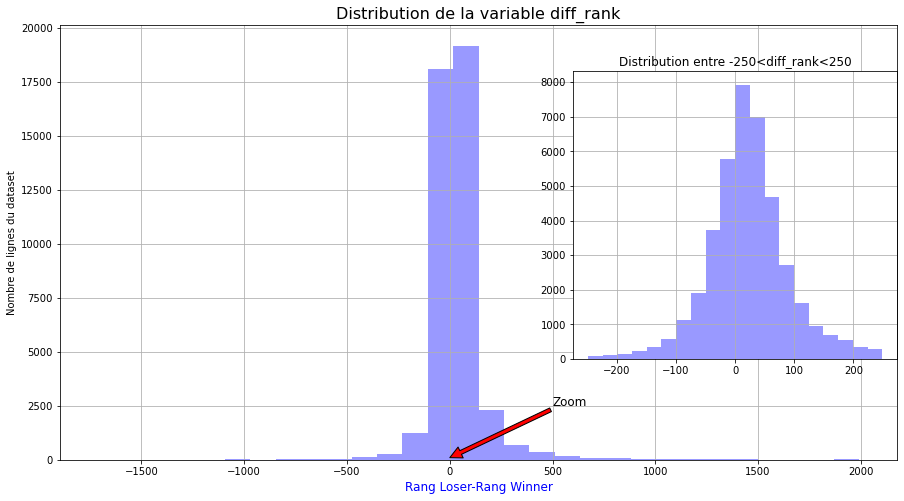

In [386]:
#Création graphique histogramme de distribution de la variable diff_rank
plt.figure(figsize=(15,8));
sns.distplot(atp.diff_rank,bins=30,kde=False,color="blue");
plt.xlabel("Rang Loser-Rang Winner",color="blue",fontsize=12);
plt.title("Distribution de la variable diff_rank",fontsize=16);
plt.ylabel("Nombre de lignes du dataset");
plt.grid(True);
plt.annotate("Zoom",[0,100],[500,2500],arrowprops={'facecolor':'red' },fontsize=12);
plt.axes([0.6,0.3,0.3,0.5]);
sns.distplot(atp[(atp["diff_rank"]>-250)&(atp["diff_rank"]<250)]["diff_rank"],bins=20,kde=False,color="blue");
plt.grid();
plt.title("Distribution entre -250<diff_rank<250");
plt.xlabel("");

On remarque que la plupart des valeurs se trouvent rapprochées autour d’une différence de 250 environ (en négatif ou positif). C’est dû au fait que le dataset contient beaucoup plus de lignes avec les joueurs classés autour des 250 premières places, les tournois  de seconde catégorie n'étant pas représentés. 
Les valeurs négatives au delà de -500 sont des valeurs exceptionnelles, mais à garder car elles reflètent la réalité de sur-performance ou contre-performance inhérente au sport.
Le cumul de la hauteur des barres est à l’avantage des valeurs positives, ce qui tend à confirmer l’intuition que plus un joueur est mieux classé que son adversaire, plus la probabilité qu’il gagne est forte.


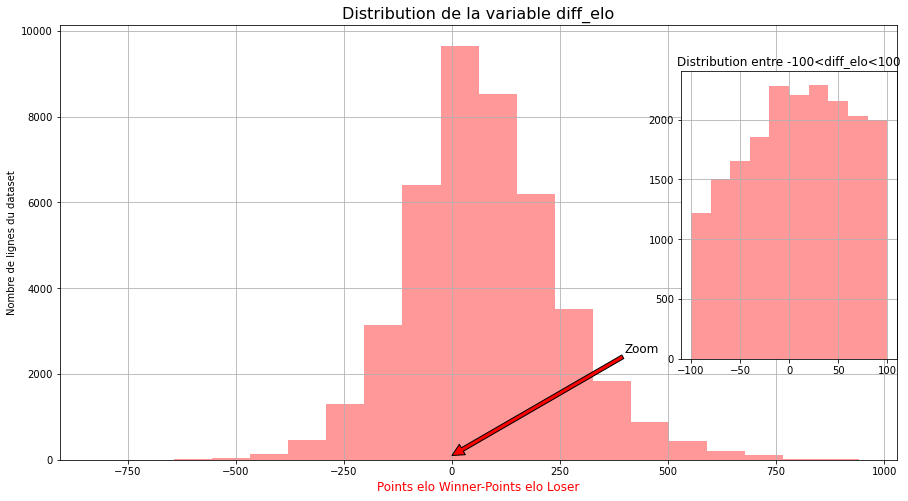

In [387]:
#Création graphique histogramme de distribution de la variable diff_elo
plt.figure(figsize=(15,8));
sns.distplot(atp.diff_elo,bins=20,kde=False,color="red");
plt.xlabel("Points elo Winner-Points elo Loser",color="red",fontsize=12);
plt.title("Distribution de la variable diff_elo",fontsize=16);
plt.ylabel("Nombre de lignes du dataset");
plt.grid(True);
plt.annotate("Zoom",[0,100],[400,2500],arrowprops={'facecolor':'red' },fontsize=12);
plt.axes([0.7,0.3,0.2,0.5]);
sns.distplot(atp[(atp["diff_elo"]>-100)&(atp["diff_elo"]<100)]["diff_elo"],bins=10,kde=False,color="red");
plt.grid();
plt.title("Distribution entre -100<diff_elo<100");
plt.xlabel("");

La différence de points elo est plus faible. On remarque que les valeurs exceptionnelles se situent en-dessous d’une différence de -500 points entre le perdant et le gagnant. 
Le graphique principal et son zoom confirment également un poids plus fort des cas où le gagnant possède un nombre de points aux classement elo plus élevé que son adversaire.


Pour notre projet, nous avons créé en première partie la variable cible “diff_set” qui correspond à la soustraction entre les sets gagnés par le gagnant du match, et les sets gagnés par le perdant. Cette variable annonce le gagnant ET le score. Elle est fortement corrélé à la colonne “Best Of” : un match en 3 sets gagnants n’aura pas le même score qu’un match en 5 sets gagnants.

Il nous reste à prouver l’importance de la variable “elo” sur cette variable cible. (Nous nous concentrons sur la variable 'elo' qui est plus pertinente que le classemement, relativement figé dans un court temps).

Pour cela, on divise le dataset en deux partie : une partie au meilleur des 5 manches, l'autre au meilleur des 3 manches (les scores ne sont en effet pas comparables).
Chaque parti va être divisée en 10 quantiles de la colonne “diff_elo”.
On trace ensuite les 2 histogrammes des scores par quantile.

In [409]:
# Graphique qui prouve l'utilité de la différence de points elo en fonction du score du match
atp.loc[atp["Best of"]==5,"diff_elo_2"]=pd.qcut(atp.loc[atp["Best of"]==5,"diff_elo"],q=10) #on sépare la variable diff_elo en 10 quantiles
atp.loc[atp["Best of"]==3,"diff_elo_2"]=pd.qcut(atp.loc[atp["Best of"]==3,"diff_elo"],q=10)

atp.groupby(["diff_elo_2","Best of"],as_index=False).count().sort_values(by="Best of")

,diff_elo_2,Best of,ATP,Location,Tournament,Date,Series,Court,Surface,Round,...,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo,diff_rank,diff_elo,diff_sets,Année
0,"(-818.716, -134.369]",3,3497,3497,3497,3497,3497,3497,3497,3497,...,2772,3237,3237,3497,3497,3497,3497,3497,3497,3497
17,"(280.873, 892.638]",3,3497,3497,3497,3497,3497,3497,3497,3497,...,2996,3406,3409,3497,3497,3497,3497,3497,3497,3497
15,"(196.178, 280.873]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2794,3306,3306,3496,3496,3496,3496,3496,3496,3496
13,"(141.277, 196.178]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2648,3167,3167,3496,3496,3496,3496,3496,3496,3496
11,"(97.024, 141.277]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2512,3012,3012,3496,3496,3496,3496,3496,3496,3496
8,"(19.505, 56.537]",3,3497,3497,3497,3497,3497,3497,3497,3497,...,2297,2800,2800,3497,3497,3497,3497,3497,3497,3497
9,"(56.537, 97.024]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2427,2908,2908,3496,3496,3496,3496,3496,3496,3496
4,"(-63.342, -16.744]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2378,2855,2855,3496,3496,3496,3496,3496,3496,3496
2,"(-134.369, -63.342]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2511,3000,3000,3496,3496,3496,3496,3496,3496,3496
6,"(-16.744, 19.505]",3,3496,3496,3496,3496,3496,3496,3496,3496,...,2142,2654,2654,3496,3496,3496,3496,3496,3496,3496


On remarque que les quantiles ne sont pas exactement exact, mais à la marge. C'est dû au bornes des quantiles qui contiennent plusieurs vraies valeurs qui sont attribuées à un même quantile.

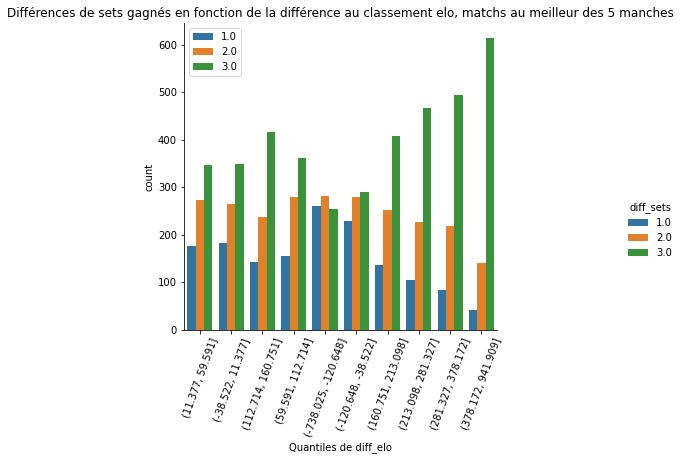

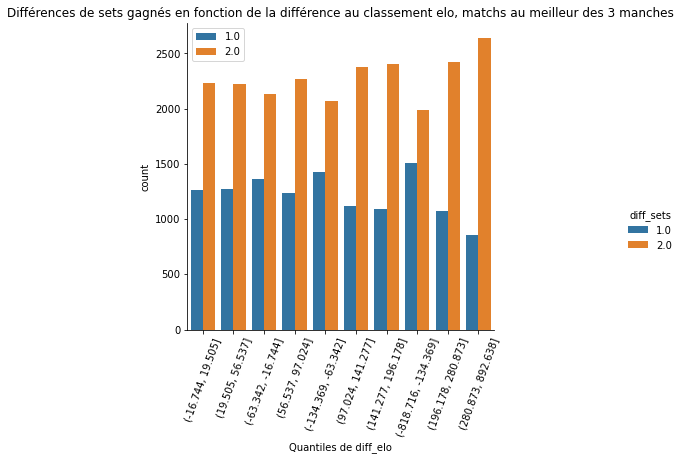

In [410]:
# Graphique qui prouve l'utilité de la différence de points elo en fonction du score du match
atp[atp["Best of"]==5].sort_values(by="diff_elo_2")
atp[atp["Best of"]==3].sort_values(by="diff_elo_2")
sns.catplot("diff_elo_2",data=atp[atp["Best of"]==5],hue="diff_sets",kind='count');
plt.xticks(rotation=70);plt.title("Différences de sets gagnés en fonction de la différence au classement elo, matchs au meilleur des 5 manches");
plt.xlabel("Quantiles de diff_elo");
plt.legend(loc="upper left");
sns.catplot("diff_elo_2",data=atp[atp["Best of"]==3],hue="diff_sets",kind='count');
plt.xticks(rotation=70);
plt.title("Différences de sets gagnés en fonction de la différence au classement elo, matchs au meilleur des 3 manches");
plt.xlabel("Quantiles de diff_elo");
plt.legend(loc="upper left");

**Commentaire général** : La différence de sets gagnés en quantité est clairement à l’avantage du joueur le mieux classé quand on a une grande différence de points. 

**Commentaire premier graphique** : On aperçoit une augmentation de la barre verte (diff=3) une fois la différence de points positive: cela montre que plus la différence est grande entre un joueur favori gagnant et un joueur non favori, moins le gagnant perdra de sets.
Les barres vertes sont bizarrement assez hautes avant de redescendre à des niveaux de différences de points moins importants. Cela pourrait démontrer qu'une victoire surprise d'un joueur non favori est marquée par une contre performance particulière du joueur favori.

La barre orange (diff=2, match plus serré) fluctue moins mais diminue globalement avec le temps.
La barre bleue, elle, agumente avant de diminuer (diff=1): pour les différence positives marquées,  plus l’écart est positif, plus le perdant aura du mal à gagner 2 sets.


**Commentaire second graphique** : La barre bleue (diff=1) garde des niveaux assez stables avant de diminuer quand l'écart de classement elo est à l'avantage du joueur favori. Cela prouve que même si les matchs au meilleur des 3 manches sont plus serrés, plus le Joueur non favori et perdant a un classement éloigné du gagant, moins le match serra serré. 
La barre orange confirme relativement cette tendance.


## 2-2. Importance de la variable Surface <a class="anchor" id="section_2_2"></a>
Intuitivement, les résultat des joueurs sur les 4 surfaces de jeu influent sur une prédiction de match. Reste à confirmer cette intuition.

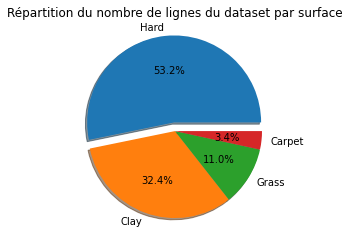

In [22]:
atp_surface=atp.groupby("Surface",as_index=False).agg({"Winner":"count"})
plt.pie(atp_surface.Winner,labels=["Hard","Clay","Grass","Carpet"],explode=(0.1,0,0,0),shadow=True,autopct='%1.1f%%'); plt.title("Répartition du nombre de lignes du dataset par surface");

On observe ainsi un déséquilibre en faveur des surfaces ‘hard’ et “clay”, qu’il faudra prendre en compte dans nos analyses.
Par la suite, on décidera d'enlever les lignes "carpet" de notre dataset, d'autant plus que cette surface a disparu du circuit depuis quelques années, et ne nous servira donc pas à prédire de  futurs matchs.

In [412]:
#Suppression lignes carpet
atp=atp[atp["Surface"]!=4]
atp.shape

(41459, 28)

Afin de visualiser les impacts de la surface sur les performances des joueurs, nous avons isolé dans un dataframe à part les % de gain de match sur chaque surface par joueur (matchs gagnés / (matchs gagnés+matchs perdus)). Le graphique ci-dessous représente les performances des 10 meilleurs joueurs (ayant un meilleur % moyen de matchs gagnés), par surface.


In [413]:
# Etude de la variable "Surface" et de son influence sur le résultat d'un match

#Calcul du % de gain par surface pour chaque joueur
win_hard=[]
for i in joueurs:#rappel : 'joueurs'=liste unique des noms des joueurs
    win=len(atp[(atp["Winner"]==i)&(atp["Surface"]==1)]) #récupération du nombre de matchs gagnés sur la surface 1 ("Hard")
    loss=len(atp[(atp["Loser"]==i)&(atp["Surface"]==1)])#récupération du nombre de matchs joués sur la surface 1 ("Hard")
    if (win==0) & (loss==0):
        win_hard.append(100) # dans le cas ou ce joueur n'a pas de résultat sur cette surface, on met la valeur "100", qu'on remplacera par la suite
    else :
        win_hard.append(win/(win+loss))

win_clay=[]
for i in joueurs:#rappel : 'joueurs'=liste unique des noms des joueurs
    win=len(atp[(atp["Winner"]==i)&(atp["Surface"]==2)]) #récupération du nombre de matchs gagnés sur la surface 2 ("Clay")
    loss=len(atp[(atp["Loser"]==i)&(atp["Surface"]==2)])#récupération du nombre de matchs joués sur la surface 2 ("Clay")
    if (win==0) & (loss==0):
        win_clay.append(100) # dans le cas ou ce joueur n'a pas de résultat sur cette surface, on met la valeur "100", qu'on remplacera par la suite
    else :
        win_clay.append(win/(win+loss))
            
win_grass=[]
for i in joueurs:
    win=len(atp[(atp["Winner"]==i)&(atp["Surface"]==3)])#récupération du nombre de matchs gagnés sur la surface 3 ("Grass")
    loss=len(atp[(atp["Loser"]==i)&(atp["Surface"]==3)])#récupération du nombre de matchs joués sur la surface 3 ("Grass")
    if (win==0) & (loss==0):
        win_grass.append(100) #même logique que précédemment
    else:
        win_grass.append(win/(win+loss))

In [414]:
#Création du dataframe recapitulant, par joueur, chaque performance sur chaque surface (% de matchs gagnés)
df_joueurs=pd.DataFrame()

for i,j in zip(["Joueurs","win_hard","win_clay","win_grass"],(joueurs,win_hard,win_clay,win_grass)):
    df_joueurs[i]=j

Il faut maintenant remplacer les valeurs =100 (i.e quand le joueur n'a pas de match enregistré sur cette surface)
Le pb est que si on les remplace par le mode de cette variable, c'est biaisé par le fait que de très bons joueurs auront de très bons résultat.
On prend donc l'hypothèse que si ces données n'existent pas c'est que ces joueurs ne sont pas très connus. On remplace les valeurs "100" par le MINIMUM sur cette colonne. 

Remarque ajouté en deuxième partie de projet : Cette manipulation aura de toute façon peu d'incidence car nous isolerons finalement ces variables par année en remplaçant les valeurs manquantes par les années précédentes pour un même joueur.Nous gardons ici cette logique pour l'instant car la partie de data visualisation n'est pas impactée.

In [415]:
df_joueurs['win_clay']=df_joueurs["win_clay"].replace(100,df_joueurs["win_clay"].min())
df_joueurs['win_hard']=df_joueurs["win_hard"].replace(100,df_joueurs["win_hard"].min())
df_joueurs['win_grass']=df_joueurs["win_grass"].replace(100,df_joueurs["win_grass"].min())

In [416]:
df_joueurs.head()

,Joueurs,win_hard,win_clay,win_grass
0,Dosedel S.,0.476190,0.384615,0.500000
1,Kiefer N.,0.619512,0.500000,0.595238
2,Gaudio G.,0.453608,0.670833,0.333333
3,El Aynaoui Y.,0.549020,0.654321,0.538462
4,Cherkasov A.,0.333333,0.000000,0.000000


Avant de construire nore graphique, on se concentre sur les flucutations du % de victoire par surface pour les 10 meilleurs joueurs, juste pour voir visuellement l'impact sur quelques joueurs. Il serait trop long de le faire sur les 1200 joueurs.

In [417]:
#Construction du graphique de performance pour les 10 meilleurs joueurs

df_joueurs["win_mean"]=df_joueurs.iloc[:,1:4].mean(axis=1) # Ajout de la moyenne des victoires
best_10=df_joueurs.sort_values(by="win_mean",ascending=False).head(10) # Filtrage des meilleurs joueurs (meilleure moyenne de gain)

best_10_2=pd.melt(best_10,id_vars=["Joueurs"],value_vars=["win_hard","win_clay","win_grass"]) #On transpose le dataset avec la méthode melt

best_10_2.head()

,Joueurs,variable,value
0,Federer R.,win_hard,0.842632
1,Djokovic N.,win_hard,0.844660
2,Nadal R.,win_hard,0.770661
3,Murray A.,win_hard,0.782511
4,Roddick A.,win_hard,0.764706


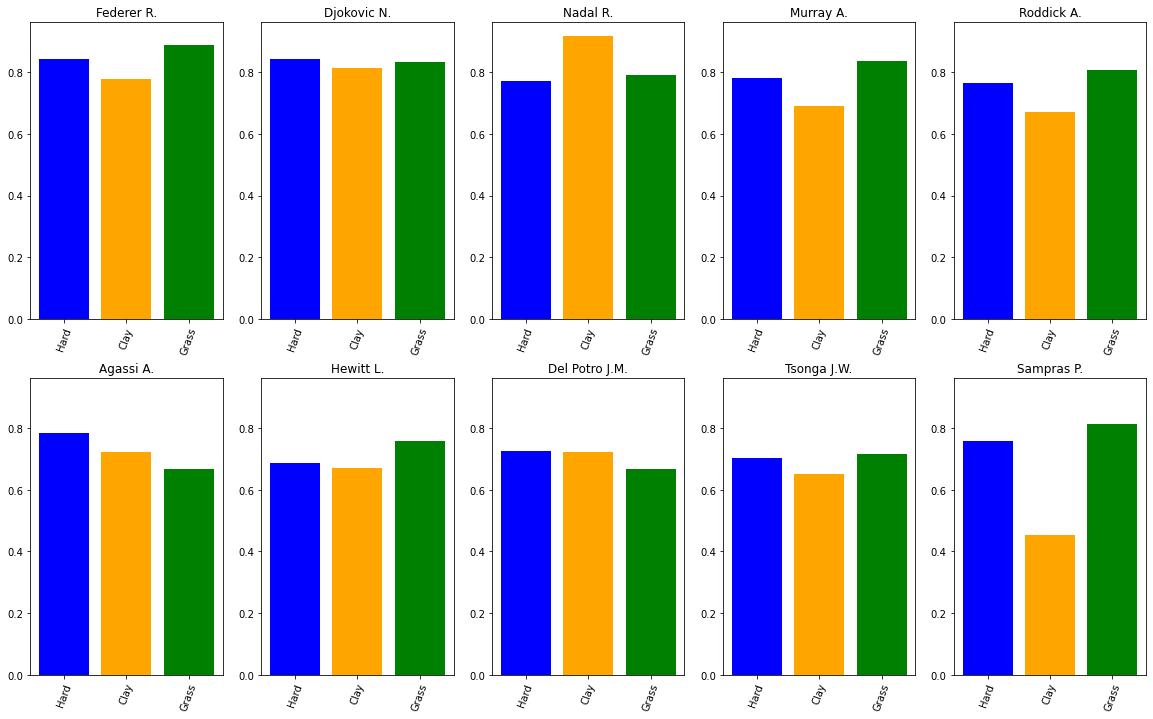

In [433]:
fig=plt.figure(figsize=(20,12));
plt.title("% de matchs gagnés par surface par joueur");
ax1=plt.subplot(1,11,1)
for i,k in zip(list(range(10)),best_10_2.Joueurs.unique()):
    plt.subplot(2,5,i+1,sharey=ax1)
    plt.bar(best_10_2[best_10_2["Joueurs"]==k]["variable"],best_10_2[best_10_2["Joueurs"]==k]["value"],color=["blue","orange","green"],width=0.8);
    plt.title(k);
    plt.xticks(["win_hard",'win_clay','win_grass'],["Hard","Clay","Grass"],rotation=70);

Les données pour ce graphique sont construites de manière à gommer les déséquilibres de nombre de lignes par surface (% de gain). Comme on peut le constater, un joueur n’aura pas la même probabilité de gagner un match en fonction de ses préférences de surface. La côte de Federer vs Nadal ne sera pas la même en fonction de s’ils se rencontrent sur terre battue ou sur gazon par exemple.
On veillera à ajouter une variable en lien avec la surface au moment de construire notre modèle.

## 2-3. Importance du winning streak <a class="anchor" id="section_2_3"></a>
Une autre variable dont les impacts sur le résultat seraient intéressants à démontrer est le “winning streak” : la série de victoires. Un joueur en pleine forme venant d’enchainer plusieurs tournois sans perdre pourrait être archi favori d’une rencontre, avec moins d’égards à son classement ou à la surface de jeu.

Le graphique qu'on veut représenter dans cette partie représente la distribution des séries de victoires d’affilée maximum par joueur.
Pour calculer cela, nous avons isolé pour chaque joueur le nombre de lignes contenant son nom dans la colonne “Winner” ou “Loser”, puis effectué un cumsum du nombre de fois où son nom était présent en colonne “Winner”. Une boucle nous a ensuite permis de compter la plus longue série lors de laquelle la colonne cumsum continuait d’augmenter de 1.


In [434]:
# On recalcule la liste joueurs, ayant supprimé des lignes avec la suppression des lignes carpet
joueurs=atp["Winner"].append(atp["Loser"]).unique()
print("Nombre de valeurs uniques= ",len(joueurs))

Nombre de valeurs uniques=  1281


In [435]:
# Création d'un tableau avec l'id du joueur et le nombre max de victoires d'affilée
dict={}
nb=[]
for k in joueurs:
    df=atp[(atp["Winner"]==k)|(atp["Loser"]==k)][["Winner","Loser"]]#pour chaque joueur k, on isole les données où il est présent en winner ou loser
    df["cum"]=np.cumsum(df["Winner"]==k) #on compte la somme cumulée du nb de fois ou la valeur k est présente en "Winner"
    nb.append(df.shape[0]) #on récupère le nombre de matchs par joueur
    # On va créer une boucle qui nous permet de calculer le nombre maximum de winning streak dans une colonne 'res'
    df["res"]=np.nan
    if df.iloc[0,2]==0:#si le joueur a perdu son premier match (ligne O), alors on initialise "res" à 0
        df.iloc[0,3]=0
    else:
        df.iloc[0,3]=1 #si le joueur a gagné son premier match (ligne O), alors on initialise "res" à 1
    for i in range(1,df.shape[0]-1):
        if df.iloc[i,2]!=df.iloc[i+1,2]:# si le cumsum augmente d'une ligne sur l'autre
            df.iloc[i,3]=df.iloc[i-1,3]+1 #alors "res" augmente de 1
        elif df.iloc[i,2]==df.iloc[i+1,2]:# si le cumsum n'augmente PAS d'une ligne sur l'autre, alors on remets "res" à 0
            df.iloc[i,3]=0 
    dict[k]=df["res"].max() # on ajoute au dictionnaire le nom du joueur et le max de win_streak

In [463]:
# Réprésentation dans un DataFrame
win_streak= pd.DataFrame.from_dict(dict,orient="index")
win_streak=win_streak.rename(columns={0:"win_streak"})

win_streak["nb matchs joués"]=nb

win_streak.sort_values(by="nb matchs joués",ascending=False)

,win_streak,nb matchs joués
Federer R.,35.0,1087
Nadal R.,32.0,927
Ferrer D.,11.0,910
Djokovic N.,38.0,788
Berdych T.,11.0,759
...,...,...
Uppal V.,0.0,1
Ittogi T.,0.0,1
Sanchez de Luna J.A.,0.0,1
Fruttero J.P.,0.0,1


On va créer maintenant une table qui compte le nombre de Joueurs pour chaque valeur de win_streak, en ajoutant une somme cumulée.
Aini, un joueur qui aura dans sa carrière gagné au maximum 10 matchs d'affilées aura aussi gagné 9 matchs, ou 8 matchs. On le prendre donc en compte dans la distribution.

In [470]:
#On somme le nombre de matchs joués
wk=win_streak.groupby("win_streak",as_index=False).agg({"nb matchs joués":"count"})
wk=wk.sort_values(by="win_streak")
wk=wk.rename(columns={"nb matchs joués":"Nb Joueurs"})
wk=wk.sort_values(by="win_streak",ascending=False)
wk["Nb Joueurs cum"]=np.cumsum(wk["Nb Joueurs"])
wk.head(10)

,win_streak,Nb Joueurs
0,0.0,502
1,1.0,233
2,2.0,159
3,3.0,106
4,4.0,76
5,5.0,52
6,6.0,38
7,7.0,29
8,8.0,21
9,9.0,18


<Figure size 1080x576 with 0 Axes>

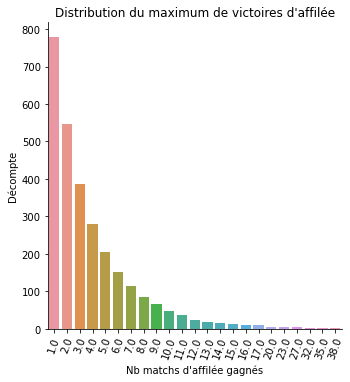

In [481]:
# Création du graphique représentant la répartition du win_streak max par nombre de matchs joués
plt.figure(figsize=(15,8));
sns.catplot("win_streak",'Nb Joueurs cum',data=wk[wk["win_streak"]!=0],kind="bar");
plt.xticks(rotation=70);
plt.ylabel("Décompte");
plt.xlabel("Nb matchs d'affilée gagnés")
plt.title("Distribution du maximum de victoires d'affilée");

**Commentaire**: La majorité des joueurs ne gagnent pas plus de 2 matchs d'affilés. Plus le nombre de matchs d'affilés est important, moins de joueurs atteignent cette valeur.

Le tableau ci-dessous montre la probabilité de gagner le n+1 match prochain en ayant gagné les n derniers matchs, pour une série de victoire entre 2 et 9 (celles sur lesquelles nous avons suffisamment de données)


In [484]:
#Calcul des chances de gagner le ième+1 match
d={}
for i in range(2,9):
    p=wk[(wk["win_streak"]>=i)&(wk["win_streak"]<9)]["Nb Joueurs cum"].sum()/wk[(wk["win_streak"]>=i-1)&(wk["win_streak"]<9)]["Nb Joueurs cum"].sum()
    d["probabilité de gagner le",i,"ieme match d'affilé"]=round(p,2)
vic=pd.DataFrame.from_dict(d,orient='index')
vic

,0
"(probabilité de gagner le, 2, ieme match d'affilé)",0.69
"(probabilité de gagner le, 3, ieme match d'affilé)",0.69
"(probabilité de gagner le, 4, ieme match d'affilé)",0.68
"(probabilité de gagner le, 5, ieme match d'affilé)",0.67
"(probabilité de gagner le, 6, ieme match d'affilé)",0.63
"(probabilité de gagner le, 7, ieme match d'affilé)",0.57
"(probabilité de gagner le, 8, ieme match d'affilé)",0.43


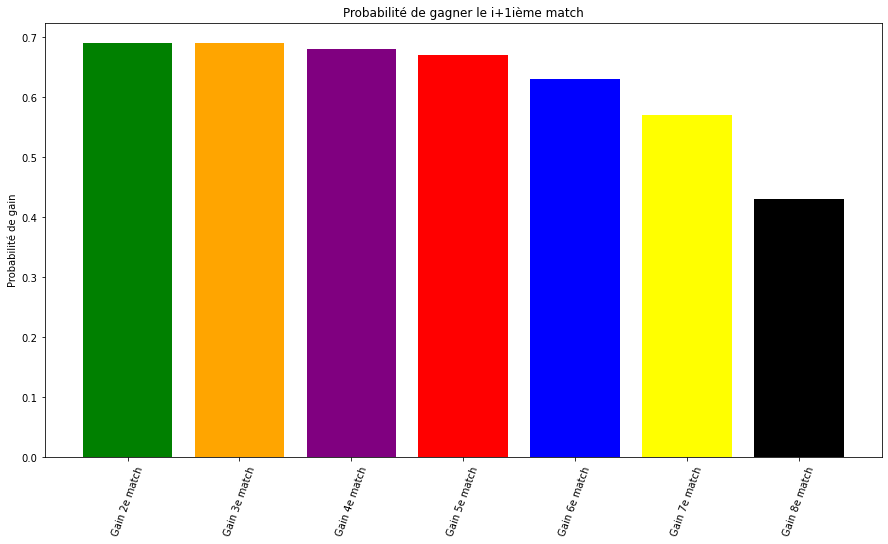

In [485]:
# Représentation graphique de cette probabilité
plt.figure(figsize=(15,8));
plt.bar(range(7),vic[0],color=("green",'orange','purple','red','blue','yellow','black'));
plt.title("Probabilité de gagner le i+1ième match");
plt.ylabel('Probabilité de gain')
plt.xticks(range(7),["Gain 2e match","Gain 3e match","Gain 4e match","Gain 5e match","Gain 6e match","Gain 7e match","Gain 8e match"],rotation=70);


Plus un joueur gagne de matchs, moins forte est sa probabilité de gagner le suivant pour une série de victoire entre 2 et 9. Cela confirme donc notre intuition de non corrélation de cette variable de winning streak avec la variable cible.

Cette variable est donc à exclure de nos variables explicatives. 


## 2-4. Précisions des côtes Pinnacle et Bet365 , et de la proba elo <a class="anchor" id="section_2_4"></a>
Le dataset contient les côtes (victoire du gagnant et victoire du perdant) prédites en amont par Pinnacle et Bet365 pour respectivement 73%  et 87% du dataset atp, ainsi que la probabilité elo d’une victoire du gagnant en amont du match, basée sur la différence au classement ELO.

Nous aimerions montrer visuellement la pertinence de ces probabilités au regard des résultats connus à posteriori. Nous avons donc isolé dans un dataframe les prédictions correctes des bookmakers, c’est-à-dire:
- Quand PSW<PSL
- Quand B365W<B365L
- Quant proba_elo>0.5


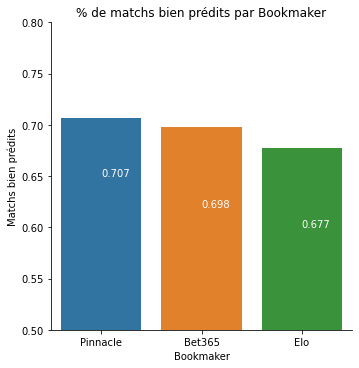

In [53]:
# Etude bookmakers
atp_cote=atp.dropna(subset=["PSW","PSL","B365W","B365L"])
w_PS=atp_cote[atp_cote["PSW"]<atp_cote["PSL"]].shape[0]/atp_cote.shape[0]
w_B365=atp_cote[atp_cote["B365W"]<atp_cote["B365L"]].shape[0]/atp_cote.shape[0]
w_elo=atp_cote[atp_cote["proba_elo"]>0.5].shape[0]/atp_cote.shape[0]

#Création du dataset et représentation des % bien prédits par les 2 bookmakers et les prédictions Elo
df_cote=pd.DataFrame({"Bookmaker":["Pinnacle","Bet365","Elo"],"Matchs bien prédits":[w_PS,w_B365,w_elo]})
sns.catplot("Bookmaker","Matchs bien prédits",data=df_cote,kind="bar");
plt.ylim([0.5,0.8]);
plt.title("% de matchs bien prédits par Bookmaker");
plt.text(0,0.65,round(w_PS,3),color="white");
plt.text(1,0.62,round(w_B365,3),color="white");
plt.text(2,0.60,round(w_elo,3),color="white");

On remarque que les 3 prédictions sont dans un mouchoir de poche. Pinnacle arrive en tête avec 0.706% d’issues correctement prédites. La méthode Elo est la moins efficace, ce qui est logique car elle prend moins de variables en compte que les bookmakers logiquement.
Il est maintenant intéressant de vérifier le lien entre l’importance des côtes données vis à vis du score. Est-ce qu’un score plus ou moins serré pouvait se sentir dans les côtes données en avant du match ? Ici nous choisissons de nous focaliser sur les côtes données aux gagnants.
Dans la série de graphiques ci-dessous, nous avons analysé la répartition du coeur des variable PSW, B365W et proba_elo en fonction de la variable créée diff_sets (sets gagnant-sets perdants), par typologie de match (au meilleur des 3 ou 5 sets)


### PSW

<ipython-input-56-65c7aaae3d27>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot("diff_sets","PSW",hue="Best of",data=atp_cote[atp["PSW"]<5])


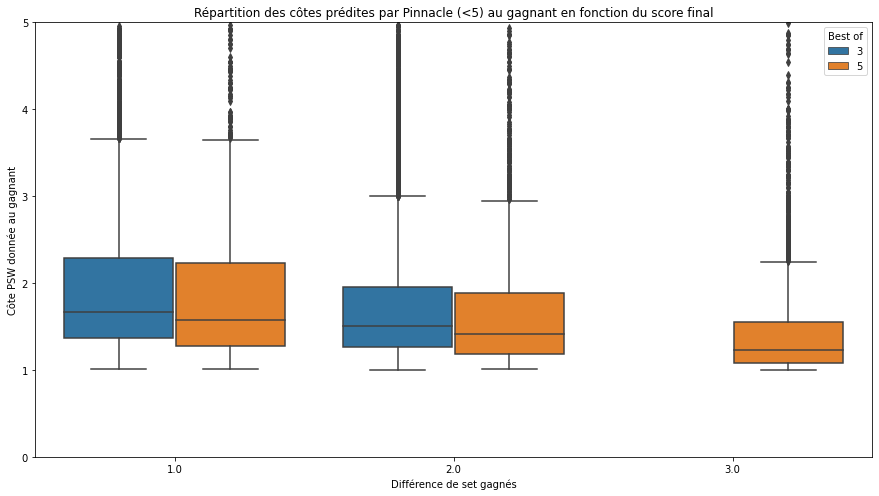

In [56]:
# Boxplot des cotes en fonction du score final
#Pinnacle
plt.figure(figsize=(15,8))
sns.boxplot("diff_sets","PSW",hue="Best of",data=atp_cote[atp["PSW"]<5])
plt.ylim([0,5]);
plt.xlabel("Différence de set gagnés");
plt.ylabel('Côte PSW donnée au gagnant');
plt.title("Répartition des côtes prédites par Pinnacle (<5) au gagnant en fonction du score final");

On peut constater dans le graphiques (que ce soit au meilleur des 3 ou 5 manches) que plus le score a finalement été serré (diff_set=1 ou 2), plus la variance des côtes est forte (étalement). Cela s’explique par le fait que plus la cote est élevée, moins la probabilité que le joueur A gagne. Donc un score plus serré s’accompagnant d’une incertitude dans les côtes est plus forte est logique.

### Bet365

<ipython-input-59-6855b44a30fd>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot("diff_sets","B365W",hue="Best of",data=atp_cote[atp["B365W"]<5])


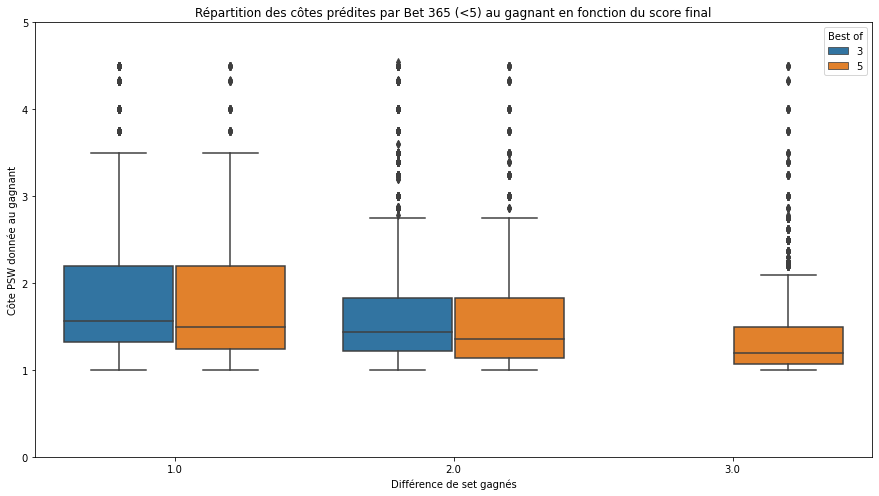

In [59]:
# B365
plt.figure(figsize=(15,8))
sns.boxplot("diff_sets","B365W",hue="Best of",data=atp_cote[atp["B365W"]<5])
plt.ylim([0,5]);
plt.xlabel("Différence de set gagnés");
plt.ylabel('Côte PSW donnée au gagnant');
plt.title("Répartition des côtes prédites par Bet 365 (<5) au gagnant en fonction du score final");


Même constat que pour PS. Les valeurs sont tout de même moins étirées que pour les côtes Pinnacle : le boxplot nous montre que la répartition des valeurs est plus centrée autour des quantiles. Il y a moins de variances dans les côtes de Bet365 

### Elo

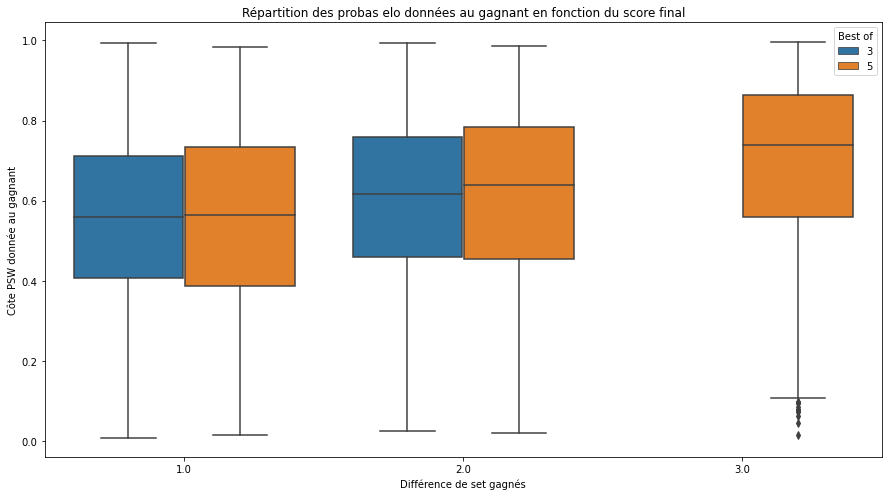

In [60]:
#elo
plt.figure(figsize=(15,8))
sns.boxplot("diff_sets","proba_elo",hue="Best of",data=atp_cote)
plt.xlabel("Différence de set gagnés");
plt.ylabel('Côte PSW donnée au gagnant');
plt.title("Répartition des probas elo données au gagnant en fonction du score final");

Ici à contrario, plus la médiane de la répartition proba_elo est tirée vers le haut, moins le score est serré. C’est logique également : proba_elo n’est pas une côte mais une probabilité. Donc plus la probabilité que le joueur A gagne est forte, moins  le score qu’il a réalisé en gagnant doit être serré, si l’on se base sur la précision de la méthode elo.

Conclusion : Ces 3 métriques seront donc intéressantes à conserver dans un dataset à part pour pouvoir les comparer à nos prédictions finales. L'objectif de notre projet étant de battre l’algorithme des bookmakers, il faudra tenter d’obtenir une meilleure accuracy qu’eux.


In [70]:
# téléchargement du dataset atp avant de passer à la partie machine learning
atp.to_csv("atp2.csv",index=False)

# Chapitre 3 : Machine Learning <a class="anchor" id="chapter3"></a>
 ## 3-1. Création de la variable historique de gain par surface par joueur <a class="anchor" id="section_3_1"></a>
Avant de commencer les étapes de Machine Learning, il nous faut alimenter les features (variables explicatives) de notre modèle.

Dans l’étape d’analyse et de datavisualisation, nous avions notamment étudié l’importance de la variable “Surface” sur les performances des joueurs. Pour rappel, il y a 3 surfaces (Hard, Clay, Grass) qui ont été encodées de 1 à 3. (NB : La surface “Carpet” n’est plus utilisée depuis quelques années sur le circuit.)

Afin de pouvoir construire le graphique d’analyse des performances des joueurs par surface, nous avions déjà créé une variable qui, par joueur et par surface, indique le pourcentage des matchs gagnés (matchs gagnés/(matchs gagnés + matchs perdus). La solution de facilité serait de reprendre cette variable et l’ajouter à nos features : pour chaque valeur de Surface et de Winner et de Loser, ajouter une colonne “%_win_surface_Winner” et “%_win_Surface_Loser” qui reprend des valeurs. Or cela biaiserait le modèle, pour une raison de temporalité. En effet, prédire des résultats de 2005 en se servant d’une variable calculée sur les années 2000 à 2018 serait “tricher” sur la valeur du modèle. Il faut se mettre dans les mêmes conditions que les bookmakers, en ayant accès seulement à des données historiques.

Il nous faut donc ajouter un niveau de complexité et calculer cette variable en prenant en compte l’année.
Ainsi, les colonnes “%_win_surface_Winner” et “%_win_Surface_Loser” prendraient en compte l’année en plus de la Surface et du Joueur. Nous choisirons ainsi en année N de prendre comme donnée la moyenne du % de victoire par surface des deux dernières années.


In [1]:
#Chargement des packages et du dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set
from os.path import os
os.getcwd()
os.chdir("C:\\Users\\nan-r\OneDrive\Documents\Perso\Formation Datascientest\Projet")

In [ ]:
# retéléchargement du dataset nettoyé en partie I.
atp=pd.read_csv("atp2.csv")

In [2]:
# On trie le dataset par date
atp=atp.sort_values(by="Date")

In [76]:
# On commence par créer un dataset qui rassemble, par an et par joueur, le % de victoire sur surface dure (gain/(gain+pertes))
win_hard=[]
win_clay=[]
win_grass=[]
annee=[]
player=[]

for i in joueurs:# Liste des noms de joueurs uniques
    for k in atp["Année"].unique():# De 2000 à 2018
        winh=len(atp[(atp["Année"]==k)&(atp["Winner"]==i)&(atp["Surface"]==1)]) #récupération du nombre de matchs gagnés sur la surface 1 ("Hard")
        lossh=len(atp[(atp["Année"]==k)&(atp["Loser"]==i)&(atp["Surface"]==1)])#récupération du nombre de matchs joués sur la surface 1 ("Hard")
        winc=len(atp[(atp["Année"]==k)&(atp["Winner"]==i)&(atp["Surface"]==2)])
        lossc=len(atp[(atp["Année"]==k)&(atp["Loser"]==i)&(atp["Surface"]==2)])
        wing=len(atp[(atp["Année"]==k)&(atp["Winner"]==i)&(atp["Surface"]==3)])
        lossg=len(atp[(atp["Année"]==k)&(atp["Loser"]==i)&(atp["Surface"]==3)])
        if (winh==0) & (lossh==0):
            if k!=2000:
                win_hard.append(win_hard[len(win_hard)-1]) # on prend le résultat de l'année précédente si on a pas de données sur cette année
            else :
                win_hard.append(0)# on met la valeur 0 si pas de donnée pour l'année 2000
        else:
            win_hard.append(winh/(winh+lossh))
        if (winc==0) & (lossc==0):
            if k!=2000:
                win_clay.append(win_clay[len(win_clay)-1]) # on prend le résultat de l'année précédente si on a pas de données sur cette année
            else :
                win_clay.append(0)# on met la valeur 0 si pas de donnée pour l'année 2000
        else: 
            win_clay.append(winc/(winc+lossc))
        if (wing==0) & (lossg==0):
            if k!=2000:
                win_grass.append(win_grass[len(win_grass)-1]) # on prend le résultat de l'année précédente si on a pas de données sur cette année
            else :
                win_grass.append(0)# on met la valeur 0 si pas de donnée pour l'année 2000
        else: 
            win_grass.append(wing/(wing+lossg))
        annee.append(k)
        player.append(i)
            
surf=pd.DataFrame(list(zip(annee,player,win_hard,win_clay,win_grass)),columns=["Année","Joueur","%win_hard","%win_clay","%win_grass"]) # Création du dataset

In [79]:
# on enregistre surf.csv
surf.to_csv("surf.csv",index=False)

In [80]:
surf.head()

,Année,Joueur,%win_hard,%win_clay,%win_grass
0,2000,Dosedel S.,0.47619,0.384615,0.5
1,2001,Dosedel S.,0.47619,0.384615,0.5
2,2002,Dosedel S.,0.47619,0.384615,0.5
3,2003,Dosedel S.,0.47619,0.384615,0.5
4,2004,Dosedel S.,0.47619,0.384615,0.5


In [4]:
#Téléchargement si besoin
surf=pd.read_csv("surf.csv")

In [82]:
# On crééé 4 nouvelles colonnes qui calculent, pour une année n, la moyenne de gain de la surface des années N-2 et N-1
surf_f=pd.DataFrame(columns=["Année","Joueur","%win_hard","%win_clay","%win_grass"])
for i in joueurs:
    surf_i=surf[surf["Joueur"]==i]
    surf_i["win_hard_date"]=np.nan
    surf_i["win_clay_date"]=np.nan
    surf_i["win_grass_date"]=np.nan
    surf_i.iloc[0,5]=surf_i.iloc[0,2]# la première ligne "année=2000" reste avec la même valeur
    surf_i.iloc[1,5]=surf_i.iloc[:1,2].mean()# on met dans la 2e ligne de win_hard_date la moyenne de win_hard sur les deux premières lignes
    surf_i.iloc[0,6]=surf_i.iloc[0,3]
    surf_i.iloc[1,6]=surf_i.iloc[:1,3].mean()
    surf_i.iloc[0,7]=surf_i.iloc[0,4]
    surf_i.iloc[1,7]=surf_i.iloc[:1,4].mean()
    for j in range(2,surf_i.shape[0]):# pour le reste du dataset (ligne>2)
        surf_i.iloc[j,5]=surf_i.iloc[j-2:j,2].mean()#win_hard_date est égal à la moyenne de win_hard sur les 2 dernières années
        surf_i.iloc[j,6]=surf_i.iloc[j-2:j,3].mean()#win_clay_date est égal à la moyenne de win_clay sur les 2 dernières années
        surf_i.iloc[j,7]=surf_i.iloc[j-2:j,4].mean()#win_grass_date est égal à la moyenne de win_grass sur les 2 dernières années
    surf_f=pd.concat([surf_f,surf_i])

<ipython-input-82-dec607f7930d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_i["win_hard_date"]=np.nan
<ipython-input-82-dec607f7930d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_i["win_clay_date"]=np.nan
<ipython-input-82-dec607f7930d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [83]:
surf_f=surf_f.drop(["%win_hard","%win_clay","%win_grass"],axis=1)
surf_f.head()

,Année,Joueur,win_hard_date,win_clay_date,win_grass_date
0,2000,Dosedel S.,0.47619,0.384615,0.5
1,2001,Dosedel S.,0.47619,0.384615,0.5
2,2002,Dosedel S.,0.47619,0.384615,0.5
3,2003,Dosedel S.,0.47619,0.384615,0.5
4,2004,Dosedel S.,0.47619,0.384615,0.5


In [3]:
# A lire si nouvelle session notebook
surf_f=pd.read_csv("surf_f.csv")

On va maintenant merger notre dataset atp et la base créée sur la colonne "winner", afin de récupérer dans une nouvelle colonne le % de victoire du joueur "Winner" conditionné par la valeur de la surface et de l'année pour chaque ligne

In [4]:
atp2=pd.merge(atp,surf_f,left_on=["Winner","Année"],right_on=['Joueur',"Année"])

In [5]:
# On introduit dans atp la colonne "win%_surface_W" qui ne récupère que les valeurs %win en fonction de la valeur 'Surface' de cette ligne
for i in range(atp2.shape[0]):
    if atp2.loc[i,"Surface"]==1:
        atp2.loc[i,"win%_surface_W"]=atp2.loc[i,"win_hard_date"]
    elif atp2.loc[i,"Surface"]==2:
        atp2.loc[i,"win%_surface_W"]=atp2.loc[i,"win_clay_date"]
    elif atp2.loc[i,"Surface"]==3:
        atp2.loc[i,"win%_surface_W"]=atp2.loc[i,"win_grass_date"]

# On supprime la colonne "joueurs", "win_clay","win_grass","win_carpet","win_hard" et on rebascule sur atp
atp=atp2.drop(["Joueur", "win_clay_date","win_grass_date","win_hard_date"],axis=1)

In [94]:
# On vérifie pour un joueur les valeurs
print(atp[(atp["Winner"]=="Federer R.")&(atp["Surface"]==1)&(atp["Année"]==2002)][["Surface","win%_surface_W","Année"]])
print(atp[(atp["Winner"]=="Federer R.")&(atp["Surface"]==2)&(atp["Année"]==2009)][["Surface","win%_surface_W","Année"]])

      Surface  win%_surface_W Année
3317        1          0.5625  2002
3318        1          0.5625  2002
3319        1          0.5625  2002
3320        1          0.5625  2002
3321        1          0.5625  2002
3322        1          0.5625  2002
3323        1          0.5625  2002
3324        1          0.5625  2002
3325        1          0.5625  2002
3326        1          0.5625  2002
3327        1          0.5625  2002
3328        1          0.5625  2002
3329        1          0.5625  2002
3330        1          0.5625  2002
3331        1          0.5625  2002
3332        1          0.5625  2002
3345        1          0.5625  2002
3346        1          0.5625  2002
3347        1          0.5625  2002
3348        1          0.5625  2002
3349        1          0.5625  2002
3350        1          0.5625  2002
3351        1          0.5625  2002
3352        1          0.5625  2002
3353        1          0.5625  2002
3354        1          0.5625  2002
3355        1          0.562

In [6]:
#Même chose pour le perdant
atp2=pd.merge(atp,surf_f,left_on=["Loser","Année"],right_on=['Joueur',"Année"])
for i in range(atp2.shape[0]):
    if atp2.loc[i,"Surface"]==1:
        atp2.loc[i,"win%_surface_L"]=atp2.loc[i,"win_hard_date"]
    elif atp2.loc[i,"Surface"]==2:
        atp2.loc[i,"win%_surface_L"]=atp2.loc[i,"win_clay_date"]
    elif atp2.loc[i,"Surface"]==3:
        atp2.loc[i,"win%_surface_L"]=atp2.loc[i,"win_grass_date"]

# On supprime la colonne "joueurs", "win_clay","win_grass","win_carpet","win_hard"
atp=atp2.drop(["Joueur", "win_clay_date","win_grass_date","win_hard_date"],axis=1)

In [96]:
# On vérifie pour un joueur les valeurs
print(atp[(atp["Loser"]=="Federer R.")&(atp["Surface"]==1)&(atp["Année"]==2002)][["Surface","win%_surface_W","Année"]])
print(atp[(atp["Loser"]=="Federer R.")&(atp["Surface"]==2)&(atp["Année"]==2009)][["Surface","win%_surface_W","Année"]])

      Surface  win%_surface_W Année
3086        1        0.250000  2002
3087        1        0.640000  2002
3088        1        0.666667  2002
3089        1        0.625000  2002
3091        1        0.705426  2002
3093        1        0.619048  2002
3094        1        0.750000  2002
3096        1        0.606061  2002
3097        1        0.472222  2002
3099        1        0.741935  2002
3100        1        0.782609  2002
       Surface  win%_surface_W Année
21849        2        0.818452  2009
21851        2        0.523923  2009


## 3-2. Création du dataset d'analyse pour notre modèle de Machine Learning <a class="anchor" id="section_3_2"></a>
Une fois nos deux nouvelles variables explicatives créées (voir a et b), nous les avons ajoutées au dataset central “atp” en mergeant par joueur et en triant ensuite par année et “Surface”.

Nous pouvons maintenant isoler nos variables explicatives dans un dataset à part :
- Best of
- diff_rank
- diff_elo
- %win_surface_W
- %win_surface_L

NB : Nous garderons aussi dans un premier temps (avant étape d'algorithme) les colonnes "Date","proba_elo","PSW","PSL","B365W" et "B365L", dont nous avons besoin également pour d'autres raisons (tri par date avant split, comparaison bookmakers suite aux prédictions)

Afin de pouvoir prédire une variable cible qui serait une colonne “Gagnant” = J1 ou J2, nous décidons de séparer le dataset en 2 et de créer les colonnes “J1” et “J2”:

**Nous faisons le choix de ne pas garder le nom des joueurs comme variable explicative, pour plusieurs raisons:**
- Nous avons peu de données relatives aux joueurs individuellement : coup fort, âge, face à face
- La variable %win_surface (Winner ou Loser) contient déjà intrinséquement des données relatives aux joueurs, car elle a été construite en prenant le nom particulier du joueur. On garde donc de l'information individualisée ici.

La première moitié des données filtre les cas ou le favori au classement elo a gagné.
- la colonne “Winner” devient “J1” et tous les noms des joueurs sont remplacés par la valeur “1”
- la colonne “Loser” devient “J2” et tous les noms des joueurs sont remplacés par la valeur “2”
- la colonne “diff_rank” devient “diff_rankJ1J2”
- la colonne “diff_elo” devient “diff_rankJ1J2”
- la colonne “%win_surface_W” devient “%win_surface_J1”
- la colonne “%win_surface_L” devient “%win_surface_J2”
- on créé la colonne “Gagnant” qui prend la valeur “Joueur 1”

La seconde moitié des données filtre les cas ou le favori au classement elo a perdu.
- la colonne “Winner” devient “J2” et tous les noms des joueurs sont remplacés par la valeur “2”
- la colonne “Loser” devient “J1” et tous les noms des joueurs sont remplacés par la valeur “1”
- la colonne “diff_rank” devient “diff_rankJ1J2” et est multipliée par -1
- la colonne “diff_elo” devient “diff_rankJ1J2” et est multipliée par -1
- la colonne “%win_surface_W” devient “%win_surface_J2”
- la colonne “%win_surface_L” devient “%win_surface_J1”
- on créé la colonne “Gagnant” qui prend la valeur “Joueur 2”

Une fois ces deux moitiés de datasets mergées de nouveau, ces transformations nous permettent d’avoir une nouvelle base de données qui mélange dans les mêmes colonnes les variables explicatives des gagnants et des perdants, et d’avoir une variable cible à prédire “Gagnant”, qui peut prendre: soit la valeur “Joueur 1” (si le Joueur favori a gagné), soit la valeur “Joueur 2” (si le Joueur non favori a gagné).

In [171]:
#On télécharge si besoin
atp=pd.read_csv("atp3.csv")
atp=atp.sort_values(by="Date").reset_index(drop=True)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,elo_winner,elo_loser,proba_elo,diff_rank,diff_elo,diff_sets,Année,diff_elo_2,win%_surface_W,win%_surface_L
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,1,1,3,Dosedel S.,...,1500.000000,1500.0,0.500000,14,0.000000,2.0,2000,"(-12.633, 25.424]",0.476190,0.500000
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,1,1,3,Caratti C.,...,1500.000000,1500.0,0.500000,8,0.000000,1.0,2000,"(-12.633, 25.424]",0.333333,0.250000
2,2,Chennai,Gold Flake Open,2000-01-03,International,Outdoor,1,2,3,Manta L.,...,1483.263693,1500.0,0.475933,8,-16.736307,2.0,2000,"(-59.725, -12.633]",0.400000,0.250000
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,1,1,3,El Aynaoui Y.,...,1500.000000,1500.0,0.500000,45,0.000000,1.0,2000,"(-12.633, 25.424]",0.555556,0.222222
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,1,5,3,El Aynaoui Y.,...,1498.564127,1500.0,0.497934,50,-1.435873,2.0,2000,"(-12.633, 25.424]",0.555556,0.550000


On va diviser le dataset de manière à avoir en Joueur 1 le favori du match (avec un classement elo plus important que le joueur 2), donc quand diff_elo>=0.
Ainsi on pourrait s'attendre à ce que le joueur 1 gagne systématiquement, quand ce ne sera pas le cas.
Il faudra identifier s'il arrive que l'algorithme prenne des risques en misant sur le joueur 2 ou non.

In [284]:
#On divise le dataset 
d=["Date","Best of","Winner","Loser","diff_rank","diff_elo","win%_surface_W","win%_surface_L","PSW","PSL","B365W","B365L","proba_elo",]
atp_dt=atp.loc[:,d]
atp_j1=atp_dt[atp_dt["diff_elo"]>=0]
atp_j2=atp_dt[atp_dt["diff_elo"]<0]

# Création du dataset ou le Winner devient le J1 et le Loser le J2
atp_j1=atp_j1.rename(columns={"Winner":"J1","Loser":"J2","win%_surface_W":"win%_surface_J1","win%_surface_L":"win%_surface_J2","diff_rank":"diff_rankJ1J2","diff_elo":"diff_eloJ1J2"})
atp_j1["J1"]=1
atp_j1["J2"]=2
atp_j1["Gagnant"]="Joueur 1"

# Création du dataset ou le Winner devient le J2 et le Loser le J1
atp_j2["diff_rank"]=-atp_j2["diff_rank"] #on inverse le résultat avant de changer le nom des colonnes 
atp_j2["diff_elo"]=-atp_j2["diff_elo"]#on inverse le résultat avant de changer le nom des colonnes 
atp_j2=atp_j2.rename(columns={"Winner":"J2","Loser":"J1","win%_surface_W":"win%_surface_J2","win%_surface_L":"win%_surface_J1","win%_bestof_W":"win%_bestof_J2","diff_rank":"diff_rankJ1J2","diff_elo":"diff_eloJ1J2"})
atp_j2["J1"]=1
atp_j2["J2"]=2
atp_j2["Gagnant"]="Joueur 2"

#On merge les deux
atp_ml=pd.concat([atp_j1,atp_j2])

<ipython-input-284-a31e66571117>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atp_j2["diff_rank"]=-atp_j2["diff_rank"] #on inverse le résultat avant de changer le nom des colonnes
<ipython-input-284-a31e66571117>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atp_j2["diff_elo"]=-atp_j2["diff_elo"]#on inverse le résultat avant de changer le nom des colonnes


In [285]:
#On reclasse le nouveau dataframe par année
atp_ml=atp_ml.sort_values(by="Date").reset_index(drop=True)
atp_ml.tail(20)

,Date,Best of,J1,J2,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2,PSW,PSL,B365W,B365L,proba_elo,Gagnant
41439,2018-03-01,3,1,2,39,166.521039,0.595833,0.416667,1.75,2.21,1.72,2.00,0.722836,Joueur 1
41440,2018-03-01,3,1,2,27,174.604071,0.580645,0.372222,1.47,2.95,1.44,2.75,0.732060,Joueur 1
41441,2018-03-01,3,1,2,21,90.880773,0.441077,0.458065,1.93,2.00,1.80,2.00,0.372116,Joueur 2
41442,2018-03-01,3,1,2,40,98.776308,0.857143,0.212121,1.64,2.45,1.61,2.30,0.638441,Joueur 1
41443,2018-03-02,3,1,2,10,107.652989,0.431373,0.287500,1.84,2.08,1.83,1.83,0.349850,Joueur 2
41444,2018-03-02,3,1,2,21,34.213615,0.529453,0.353755,1.74,2.26,1.72,2.10,0.549079,Joueur 1
41445,2018-03-02,3,1,2,47,238.471041,0.577935,0.415584,1.48,2.92,1.44,2.75,0.797824,Joueur 1
41446,2018-03-02,3,1,2,37,161.265943,0.369231,0.287500,1.88,2.05,1.80,2.00,0.716735,Joueur 1
41447,2018-03-02,3,1,2,-3,103.874876,0.714286,0.595833,1.77,2.20,1.80,2.00,0.645188,Joueur 1
41448,2018-03-02,3,1,2,19,195.836322,0.580645,0.857143,1.66,2.40,1.57,2.37,0.755345,Joueur 1


In [178]:
# On isole la variable cible et les variables explicatives
target=atp_ml.Gagnant
data=atp_ml.drop(["PSW","PSL","B365W","B365L","proba_elo","Date","Gagnant","J1","J2"],axis=1)#on supprime les données inutiles

NB : Pour cette première partie, on supprime les côtes de nos variables explicatives. Celles-ci ne sont présentes que pour 73% des lignes, et il est intéressant de s'en affranchir pour comparer nos scores avec ceux des bookmakers.
    Cependant, on testera par la suite le meilleur modèle sélectionné avec ces variables, pour voir établir une stratégie de pari (voir dernière partie.)

In [179]:
data.head()

,Best of,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2
0,3,14,0.0,0.476190,0.500000
1,3,8,0.0,0.333333,0.250000
2,3,45,0.0,0.555556,0.222222
3,3,106,0.0,0.545455,0.000000
4,3,-114,0.0,0.384615,0.615385


## 3-3. Première exploration d'algorithme <a class="anchor" id="section_3_3"></a>
Pour prédire le résultat (ie Gagnant =1 ou 2), nous allons utiliser des algorithmes de classification. En effet, la variable à prédire n'est pas continue, nous avons besoin, à partir de features, de prédire une classe, à savoir si le Joueur 1 ou le Joueur 2 a gagné (2 issues possibles).
Il s'agit d'une classification binaire.

Pour cela, nous choisissons de tester plusieurs modèles:
- Linear SVC
- SGD Classifier
- Logistic Regression
- KNN
- Random Forest
- Naïve Bayes
- XG Boost
- AdaBoost à partir d'un classifieur de type Decision Tree
    
Pour ces premières simulations, nous ne chercherons pas à optimiser les hyperparamètres, juste à regarder rapidement les premiers scores.

In [180]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2,shuffle=False,random_state=25)
# Shuffle=False car on va prendre les matchs dans l'ordre : on prédit les matchs futurs

On va vérifier que notre dataset atp_ml contient bien toutes les côtes Pinnacle et Bet 365,et la proba_elo pour pouvoir comparer nos prédictions à la fin. Le X_test commence à l'index 33167.
D'après les infos ci-dessous, c'est bon, toutes les côtes sont présentes sur la partie qui correspond au "test"

In [181]:
X_test.head()

,Best of,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2
33167,3,2,72.470463,0.000000,0.000000
33168,3,36,180.675531,0.539683,0.000000
33169,3,127,80.835728,0.372549,0.000000
33170,3,-4,110.224498,0.488142,0.000000
33171,3,69,29.087684,0.358333,0.533937


On normalise maintenant les données pour atténuer l'effet des outliers et pour pouvoir appliquer tout modèle sans problème. On fera attention à enlever la colonne "Best of" avant cela, avant de la réintégrer sous forme de dichotomisation.

In [105]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.drop("Best of",axis=1)),index=X_train.index,columns=X_train.drop("Best of",axis=1).columns).join(pd.get_dummies(X_train["Best of"],prefix="Best"))
X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop("Best of",axis=1)),index=X_test.index,columns=X_test.drop("Best of",axis=1).columns).join(pd.get_dummies(X_test["Best of"],prefix="Best"))

In [106]:
X_train_scaled.head()

,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2,Best_3,Best_5
0,0.021578,-0.909286,0.145073,0.502776,1,0
1,-0.830590,-1.156759,-0.982344,0.502776,1,0
2,0.983941,-1.156759,1.234366,-0.063143,1,0
3,-0.727742,-1.156759,-0.255090,0.691416,1,0
4,-0.940784,-1.021509,-2.360298,0.125496,1,0


In [13]:
X_test_scaled.head()

,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2,Best_3,Best_5
33167,-0.066590,0.730851,-0.369974,0.604404,1,0
33168,0.050950,0.901099,-0.851477,0.141733,1,0
33169,0.601920,-0.444062,-1.090466,-0.440337,1,0
33170,-0.154745,-0.788939,-0.372547,0.271082,1,0
33171,-0.029859,-0.035630,-0.851477,0.052626,1,0


In [107]:
#Modèle Logistic Regression
from sklearn import linear_model
clf_lr = linear_model.LogisticRegression(max_iter=2000)
clf_lr.fit(X_train_scaled,y_train)
score_lr= clf_lr.score(X_test_scaled,y_test)

# Modèle Linear SVC
from sklearn import svm
clf_svc=svm.LinearSVC()
clf_svc.fit(X_train_scaled, y_train)
score_svc=clf_svc.score(X_test_scaled,y_test)

# Modèle SGD Classifier
clf_sgd=linear_model.SGDClassifier(loss="log")
clf_sgd.fit(X_train_scaled, y_train)
score_sgd=clf_sgd.score(X_test_scaled,y_test)

#Modèle Random Forest
from sklearn import ensemble
clf_rf=ensemble.RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=321)
clf_rf.fit(X_train_scaled,y_train)
score_rf= clf_rf.score(X_test_scaled, y_test)

#Modèle KNN
from sklearn import neighbors
clf_knn=neighbors.KNeighborsClassifier(n_neighbors=7,metric="minkowski")
clf_knn.fit(X_train_scaled, y_train)
score_knn= clf_knn.score(X_test_scaled, y_test)

#Modèle Gaussian Naïve Bayes
from sklearn.naive_bayes import GaussianNB
clf_gnb=GaussianNB()
clf_gnb.fit(X_train_scaled, y_train)
score_gnb= clf_gnb.score(X_test_scaled, y_test)

#Modèle XGBoost
import xgboost
boost = xgboost.XGBClassifier(objective="binary:logistic",max_depth=6)
boost.fit(X_train_scaled,y_train)
score_boost= boost.score(X_test_scaled, y_test)

#Modèle AdaBoost sur un decision tree classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train_scaled,y_train)
ada = AdaBoostClassifier(base_estimator=dtc,n_estimators=100)
ada.fit(X_train_scaled,y_train)
score_ada= ada.score(X_test_scaled, y_test)

C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [108]:
pd.DataFrame(([score_lr,"Logistic Regression"],[score_svc,"Linear SVC"],[score_sgd,"SGD Classifier"],[score_rf,"Random Forest"],[score_knn,"KNN"],[score_gnb,"Gaussian Naive Bayes"],[score_boost,"XGBoost"],[score_ada,"AdaBoost"]),columns=["Score","Modèle",])

,Score,Modèle
0,0.679812,Logistic Regression
1,0.679691,Linear SVC
2,0.677038,SGD Classifier
3,0.659672,Random Forest
4,0.652315,KNN
5,0.653521,Gaussian Naive Bayes
6,0.673058,XGBoost
7,0.594308,AdaBoost


On remarque que les scores sont assez proches entre les modèles.
Dans la partie 1, on avait vu que les bookmakers avait prédit correctement 70.7% pour Pinnacle, 69.8% pour Pinnacle, et que la proba_elo avait prédit correctement 67.7%

Les modèles Logistic Regressionn, SVC et SGD semblent déjà plus performants en battant la probabilité ELO et en s'approchant des bookmakers.

Il faudrait de plus recalculer ces % de bonnes prédictions des bookmakers en isolant juste le set de test.

En recalculant sur le dataset filtre sur les même lignes que l'ensemble de test (voir ci-dessous), on s'aperçoit que les % restent globalement les mêmes.

**Attention cependant, la méthode qui calcule s'ils ont raison ou tort (comparaison des côtes) n'est pas forcément la meilleure approche.** On verra cela par la suite.

In [242]:
# Etude bookmakers
atp_test=atp_ml.loc[33167:,:]
w_PS=atp_test[atp_test["PSW"]<atp_test["PSL"]].shape[0]/atp_test.shape[0]
w_B365=atp_test[atp_test["B365W"]<atp_test["B365L"]].shape[0]/atp_test.shape[0]
w_elo=atp_test[atp_test["proba_elo"]>0.5].shape[0]/atp_test.shape[0]
pd.DataFrame(([w_PS,"Pinnacle"],[w_B365,"Bet365"],[w_elo,"Elo"]),columns=["% bonnes prédictions","Source",])

,% bonnes prédictions,Source
0,0.699349,Pinnacle
1,0.690907,Bet365
2,0.674506,Elo


## 3-4. Exploration d'algorithmes détaillée <a class="anchor" id="section_3_4"></a>
Essayons de sélectionner les meilleurs hyperparamètres par modèle en utilisant la validation croisée. On se concentrera sur la regression logistique, LinearSVC, SG, XGBoost et Random Forest. La première exploration n'a pas permis de tirer de vrai conclusions quand a la force d'un modèle par rapport à un autre.
KNN étant un modèle trop simpliste et ayant obtenu un score plus faible que les autres lors de la première exploration, il ne sera pas l'objet d'une exploration plus poussée.
Quand au modèle Gaussian Naive Bayes, il ne nécessite pas de règler d'hyperparamètres.
Le modèle AdaBoost est également mis de côté car peu performant lors de l'exploration.

In [109]:
# On choisit d'abord une méthode de division en ensemble de validations.
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=5, shuffle=True)

### Logistic Regression <a class="anchor" id="section_3_4_1"></a>

In [114]:
#Modèle Logistic Regression avec GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid_lr={"solver":["liblinear","lbfgs","newton-cg"],"C":[0.001,0.01,0.1,1,10]}
grid_lr=GridSearchCV(estimator=clf_lr,param_grid=param_grid_lr,scoring="accuracy",cv=cv)
grille_lr=grid_lr.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grille_lr.cv_results_).loc[:,["params","mean_test_score","std_test_score"]])

                                 params  mean_test_score  std_test_score
0   {'C': 0.001, 'solver': 'liblinear'}         0.681189        0.002536
1       {'C': 0.001, 'solver': 'lbfgs'}         0.680254        0.002281
2   {'C': 0.001, 'solver': 'newton-cg'}         0.680254        0.002281
3    {'C': 0.01, 'solver': 'liblinear'}         0.680827        0.002863
4        {'C': 0.01, 'solver': 'lbfgs'}         0.680676        0.002626
5    {'C': 0.01, 'solver': 'newton-cg'}         0.680646        0.002598
6     {'C': 0.1, 'solver': 'liblinear'}         0.680948        0.002887
7         {'C': 0.1, 'solver': 'lbfgs'}         0.680857        0.002729
8     {'C': 0.1, 'solver': 'newton-cg'}         0.680857        0.002729
9       {'C': 1, 'solver': 'liblinear'}         0.680857        0.002753
10          {'C': 1, 'solver': 'lbfgs'}         0.680827        0.002731
11      {'C': 1, 'solver': 'newton-cg'}         0.680827        0.002731
12     {'C': 10, 'solver': 'liblinear'}         0.6

On remarque que les scores sont plutôt proches. 
Le modèle avec le meilleur score et la plus faible variance est celui avec les paramètres ci-dessous:

In [244]:
grid_lr.best_params_

{'C': 0.001, 'solver': 'liblinear'}

On va regarder plusieurs métriques plus en détail.

In [115]:
y_pred_lr=grid_lr.predict(X_test_scaled)
from sklearn.metrics  import classification_report
report=classification_report(y_test, y_pred_lr,output_dict=True)
df_lr=pd.DataFrame.from_dict(report).transpose()
df_lr

,precision,recall,f1-score,support
Joueur 1,0.692598,0.949616,0.800995,5597.0000
Joueur 2,0.543689,0.124675,0.202837,2695.0000
accuracy,0.681500,0.681500,0.681500,0.6815
macro avg,0.618144,0.537146,0.501916,8292.0000
weighted avg,0.644201,0.681500,0.606586,8292.0000


On remarque un excellent rappel pour la classe Joueur 1, et un rappel très mauvais pour la classe Joueur 2.
Cela veut dire que quand le Joueur 2 (le non favori) a effectivement gagné, le modèle n'a quasiment jamais prédit sa victoire.

La précision pour la classe Joueur 2 est déjà plus correcte. Cela veut dire que 54% des prédictions donnant le Joueur 2 gagnant étaient effectivement correctes.

On peut remarquer tout de même une grande difficulté à identifier correctement une victoire du "Joueur 2"

### SVC <a class="anchor" id="section3_4_2"></a>

Note : la taille de notre dataset ne nous permet pas de tester les kernel non linéaires, nous n'avons donc pas testé le modèle SVM.

In [116]:
# Modèle SVC avec GridSearchCV
param_grid_svc={"C":[0.1,1,10],"loss":["hinge","squared_hinge"],"dual":[False,True]}
grid_svc=GridSearchCV(estimator=clf_svc,param_grid=param_grid_svc,scoring="accuracy",cv=cv)
grille_svc=grid_svc.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grille_svc.cv_results_).loc[:,["params","mean_test_score","std_test_score"]])

C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 821, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

                                               params  mean_test_score  \
0          {'C': 0.1, 'dual': False, 'loss': 'hinge'}              NaN   
1   {'C': 0.1, 'dual': False, 'loss': 'squared_hin...         0.680526   
2           {'C': 0.1, 'dual': True, 'loss': 'hinge'}         0.667742   
3   {'C': 0.1, 'dual': True, 'loss': 'squared_hinge'}         0.680526   
4            {'C': 1, 'dual': False, 'loss': 'hinge'}              NaN   
5    {'C': 1, 'dual': False, 'loss': 'squared_hinge'}         0.680526   
6             {'C': 1, 'dual': True, 'loss': 'hinge'}         0.667742   
7     {'C': 1, 'dual': True, 'loss': 'squared_hinge'}         0.680526   
8           {'C': 10, 'dual': False, 'loss': 'hinge'}              NaN   
9   {'C': 10, 'dual': False, 'loss': 'squared_hinge'}         0.680526   
10           {'C': 10, 'dual': True, 'loss': 'hinge'}         0.667742   
11   {'C': 10, 'dual': True, 'loss': 'squared_hinge'}         0.680194   

    std_test_score  
0              N

C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [248]:
grid_svc.best_params_

{'C': 0.1, 'dual': False, 'loss': 'squared_hinge'}

In [117]:
y_pred_svc=grid_svc.predict(X_test_scaled)
report2=classification_report(y_test, y_pred_svc,output_dict=True)
df_svc=pd.DataFrame.from_dict(report2).transpose()
df_svc

,precision,recall,f1-score,support
Joueur 1,0.689522,0.955869,0.801138,5597.000000
Joueur 2,0.536585,0.106122,0.177200,2695.000000
accuracy,0.679691,0.679691,0.679691,0.679691
macro avg,0.613054,0.530996,0.489169,8292.000000
weighted avg,0.639816,0.679691,0.598351,8292.000000


Les résultats sont très similaires à la régression logistique. Le rappel sur la classe 2 est inférieur tout de même, le modèle a encore plus de mal à détecter les victoires du joueur 2.

### SGD Classifier <a class="anchor" id="section_3_4_3"></a>

In [118]:
# Modèle SGD avec GridSearchCV
param_grid_sgd={"average":[True,False],"loss":["log","modified_huber","squared_hinge"],"l1_ratio":np.linspace(0,1,10),"alpha":[0.01,0.1,1,10]}
grid_sgd=GridSearchCV(estimator=clf_sgd,param_grid=param_grid_sgd,scoring="accuracy",cv=cv)
grille_sgd=grid_sgd.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grille_sgd.cv_results_).loc[:,["params","mean_test_score","std_test_score"]])

C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\nan-r\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before conv

                                                params  mean_test_score  \
0    {'alpha': 0.01, 'average': True, 'l1_ratio': 0...         0.680888   
1    {'alpha': 0.01, 'average': True, 'l1_ratio': 0...         0.681038   
2    {'alpha': 0.01, 'average': True, 'l1_ratio': 0...         0.676455   
3    {'alpha': 0.01, 'average': True, 'l1_ratio': 0...         0.680827   
4    {'alpha': 0.01, 'average': True, 'l1_ratio': 0...         0.680857   
..                                                 ...              ...   
235  {'alpha': 10, 'average': False, 'l1_ratio': 0....         0.668526   
236  {'alpha': 10, 'average': False, 'l1_ratio': 0....         0.667802   
237  {'alpha': 10, 'average': False, 'l1_ratio': 1....         0.603709   
238  {'alpha': 10, 'average': False, 'l1_ratio': 1....         0.667983   
239  {'alpha': 10, 'average': False, 'l1_ratio': 1....         0.668074   

     std_test_score  
0          0.005113  
1          0.004293  
2          0.006552  
3          

In [119]:
grid_sgd.best_params_

{'alpha': 0.01, 'average': False, 'l1_ratio': 0.0, 'loss': 'modified_huber'}

In [120]:
y_pred_sgd=grid_sgd.predict(X_test_scaled)
report4=classification_report(y_test, y_pred_sgd,output_dict=True)
df_sgd=pd.DataFrame.from_dict(report4).transpose()
df_sgd

,precision,recall,f1-score,support
Joueur 1,0.690117,0.956941,0.801916,5597.000000
Joueur 2,0.546139,0.107607,0.179789,2695.000000
accuracy,0.680897,0.680897,0.680897,0.680897
macro avg,0.618128,0.532274,0.490853,8292.000000
weighted avg,0.643323,0.680897,0.599718,8292.000000


### Random Forest <a class="anchor" id="section_3_4_4"></a>

In [110]:
# Modèle RF avec GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid_rf={"n_estimators":[10,100,250],"min_samples_leaf":[1,3,5],"max_features":['sqrt',"log2"]}
grid_rf=GridSearchCV(estimator=clf_rf,param_grid=param_grid_rf,scoring="accuracy",cv=cv)
grille_rf=grid_rf.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grille_rf.cv_results_).loc[:,["params","mean_test_score","std_test_score"]])

                                               params  mean_test_score  \
0   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.654385   
1   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.659571   
2   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.659662   
3   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.657883   
4   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.668616   
5   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.668707   
6   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.664214   
7   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.671662   
8   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.672355   
9   {'max_features': 'log2', 'min_samples_leaf': 1...         0.654385   
10  {'max_features': 'log2', 'min_samples_leaf': 1...         0.659571   
11  {'max_features': 'log2', 'min_samples_leaf': 1...         0.659662   
12  {'max_features': 'log2', 'min_samp

In [111]:
grid_rf.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 250}

In [112]:
from sklearn.metrics  import classification_report
y_pred_rf=grid_rf.predict(X_test_scaled)
report3=classification_report(y_test, y_pred_rf,output_dict=True)
df_rf=pd.DataFrame.from_dict(report3).transpose()
df_rf

,precision,recall,f1-score,support
Joueur 1,0.697819,0.903162,0.787322,5597.000000
Joueur 2,0.482824,0.187755,0.270371,2695.000000
accuracy,0.670646,0.670646,0.670646,0.670646
macro avg,0.590322,0.545459,0.528847,8292.000000
weighted avg,0.627943,0.670646,0.619307,8292.000000


On atteint ici le meilleur F1 score pour la classe 2, même si le F1 score pour la classe 1 est plus faible.
Ce modèle est donc plus fort que les autres pour détecter la victoire du joueur non favori. 
Cela pourrait compter dans notre choix de modèle (voir fin de partie)

### XGBoost <a class="anchor" id="section_3_4_5"></a>

In [121]:
### XGBoost avec GridSeach
param_grid_boost={"learning_rate":[0.05,0.10,0.20],"max_depth":[3,5,10],"gamma":[0,0.01,0.1],"alpha":[0,0.01,1]}
grid_boost=GridSearchCV(estimator=boost,param_grid=param_grid_rf,scoring="accuracy",cv=cv)
grille_boost=grid_boost.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grille_boost.cv_results_).loc[:,["params","mean_test_score","std_test_score"]])

[15:55:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:55:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:55:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not 

In [261]:
grid_boost.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 10}

In [122]:
y_pred_boost=grid_boost.predict(X_test_scaled)
report4=classification_report(y_test, y_pred_boost,output_dict=True)
df_boost=pd.DataFrame.from_dict(report4).transpose()
df_boost

,precision,recall,f1-score,support
Joueur 1,0.695699,0.930498,0.796148,5597.000000
Joueur 2,0.517370,0.154731,0.238218,2695.000000
accuracy,0.678365,0.678365,0.678365,0.678365
macro avg,0.606534,0.542615,0.517183,8292.000000
weighted avg,0.637740,0.678365,0.614814,8292.000000


## 3-5. Comparaison des résultats et choix du meilleur modèle <a class="anchor" id="section_3_5"></a>
Vu la difficulté de détecter la classe 2 "Joueur 2", ie quand le joueur non favori gagne, on va choisir le modèle avec le meilleur score sur la classe Joueur 2.
On va résumer les métriques des modèles dans le tableau ci-dessous.

In [123]:
f1_J1={}
f1_J2={}
score={}

for i,k in zip([df_lr,df_svc,df_sgd,df_boost,df_rf],["Logistic Regression","Linear SVC","SGD Classifier","XGBoost","Random Forest"]):
    f1_J1[k]=round(i.loc["Joueur 1","f1-score"],4)
    f1_J2[k]=round(i.loc["Joueur 2","f1-score"],4)
    score[k]=round(i.loc["accuracy","f1-score"],4)

In [124]:
comp=pd.DataFrame.from_dict([f1_J1,f1_J2,score])
comp=comp.rename(index={0:"f1 Joueur 1",1:"f1 Joueur 2",2:"accuracy"})
comp

,Logistic Regression,Linear SVC,SGD Classifier,XGBoost,Random Forest
f1 Joueur 1,0.8010,0.8011,0.8019,0.7961,0.7873
f1 Joueur 2,0.2028,0.1772,0.1798,0.2382,0.2704
accuracy,0.6815,0.6797,0.6809,0.6784,0.6706


Sachant que notre objectif est d'avoir une rentabilité en pariant, nous allons dans notre cas choisir le modèle qui a la plus de chance de prédire une issue plus difficile à prédire pour les bookmakers.
On va choisir le modèle de Random Forest, malgré un score et un f1 score pour la classe "Joueur 1" moins importants que les autres modèles.
Notre choix est motivé par la supériorité du F1 score pour la classe "Joueur 2". Nous verrons par la suite comment établir une stratégie de pari rentable.

In [272]:
# Rappel des meilleurs paramètres
grid_rf.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 250}

Puisque notre modèle a tendance à prédire de manière naïve la victoire du Joueur 1, affichons les métriques lorsque ce résultat est prédit en particulier.

In [36]:
# On va isoler nos predictions de la classe "Joueur 1" pour calculer le score sur cette prédiction
results=pd.DataFrame(list(zip(y_pred_rf,y_test)),columns=["Prédictions RF","Résultat"])
rf_pred1=results.loc[results["Prédictions RF"]=="Joueur 1","Prédictions RF"]
y_test_1=results.loc[results["Prédictions RF"]=="Joueur 1","Résultat"]
pd.DataFrame.from_dict(classification_report(y_test_1, rf_pred1,output_dict=True)).transpose()


,precision,recall,f1-score,support
Joueur 1,0.697452,1.000000,0.821764,5037.000000
Joueur 2,0.000000,0.000000,0.000000,2185.000000
accuracy,0.697452,0.697452,0.697452,0.697452
macro avg,0.348726,0.500000,0.410882,7222.000000
weighted avg,0.486440,0.697452,0.573141,7222.000000


Le rappel est de 100% : cela veut dire que 100% des résultats "Joueur 1 gagne le match" a été prédit correctement.
Le taux de faux négatifs (ie on a prédit à tort que le Joueur 2 allait gagner) est donc nul.

La précision reste la même que celle visualisée plus haut, ce qui est logique au vu du filtre.

## 3-6. Interprétation des prédictions <a class="anchor" id="section_3_6"></a>

### Features importances <a class="anchor" id="section_3_6_1"></a>
Le graphique ci-dessous montre quelles sont les variables les plus importantes dans la détermination du résultat. Plusieurs remarques:
    
- Sans surprise, la différence au classement elo est la plus importante en termes de poids. Plus cette variable varie, plus la prédiction sera impactée
- Les variables explicatives win% par surface  pour le joueur favori 'Joueur 1' est le 2e inducteur de prédiction. Cela veut dire que notre travail sur l'ajout d'une telle variable a porté ses fruits. 
- Les variables "best of" ont peu d'influence. Cela veut dire qu'un joueur favori n'est pas beaucoup plus dur à battre en 3 manches qu'en 2 manches, en tout cas dans notre modèle

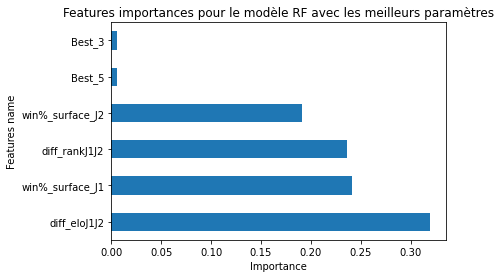

In [127]:
rf=ensemble.RandomForestClassifier(n_estimators=250,max_features="sqrt",min_samples_leaf=5)
rf.fit(X_train_scaled,y_train)
pd.Series(rf.feature_importances_,X_train_scaled.columns).sort_values(ascending=False).plot(kind="barh");
plt.title("Features importances pour le modèle RF avec les meilleurs paramètres");
plt.ylabel("Features name");
plt.xlabel("Importance");

### 3-6-2. Représentation d'un arbre de décision <a class="anchor" id="section_3_6_2"></a>
Random Forest fonctionne sur la base de plusieurs arbres de décisions. Nous pouvons tout de même en représenter un pour nous donner une idée de la manière dont le modèle a pris ses décisions à partir des features.
Cela rend le modèle plus interprétable.

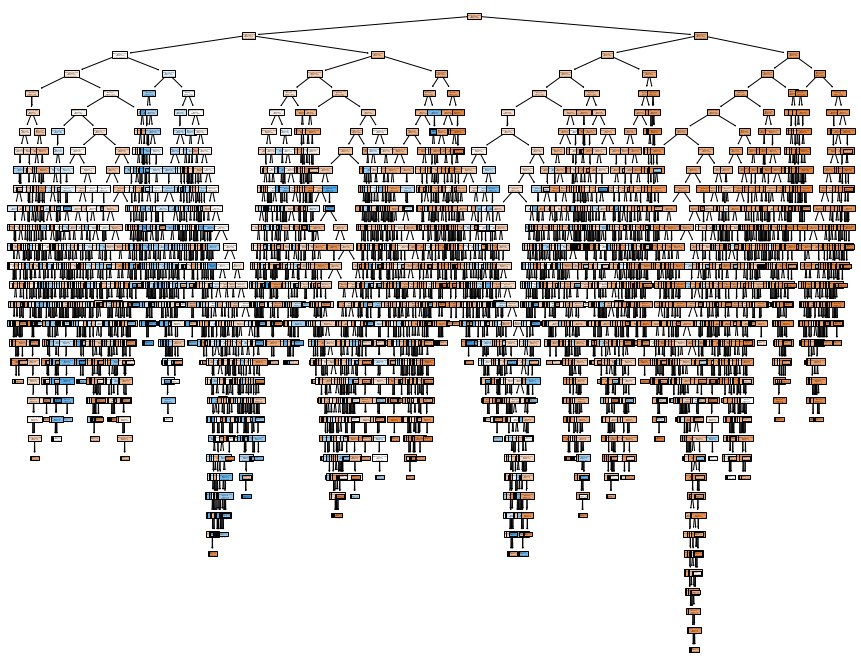

In [285]:
rf_1=rf.estimators_[2]
from sklearn.tree import plot_tree
plt.figure(figsize=(15,12));
plot_tree(rf_1, feature_names = X_train_scaled.columns.tolist(), filled=True); #proportion=True

Comme on peut le constater, cet arbre est très peu lisible. Nous avons testé d'autres paramètres dans la GridSearchCV du Random Forest en limitant le paramètre max_depth, mais nous obtenons de moins bons résultats.
Nous préférons donc ici choisir la performance plutot que l'interprétabilité visuelle de l'arbre.

## Comparaison de la faiblesse de prédiction des modèles

### Comparaison de la faiblesse de prédiction de la classe "Joueur 2" <a class="anchor" id="section_3_6_3"></a>
Afin de pouvoir vraiment jauger de la force ou la faiblesse de notre modèle, on va isoler les cas où le joueur non favori a gagné, et comparer nos prédictions avec celles des bookmakers ou du classement Elo

In [182]:
#On transforme nos côtes en probabilités 
atp_ml["PSW_prob"]=round(1/atp_ml["PSW"],4)
atp_ml["PSL_prob"]=round(1/atp_ml["PSL"],4)
atp_ml["B365W_prob"]=round(1/atp_ml["B365W"],4)
atp_ml["B365L_prob"]=round(1/atp_ml["B365L"],4)

#Dataframe des probalités bookmakers
atp_cotes=atp_ml.loc[33167:,["Gagnant","PSW_prob","PSL_prob","B365W_prob","B365L_prob","proba_elo"]]

#Dataframe des probalités bookmakers quand le J2 gagne
atp_cotes_2=atp_ml[atp_ml["Gagnant"]=="Joueur 2"].loc[33167:,["Gagnant","PSW_prob","PSL_prob","B365W_prob","B365L_prob","proba_elo"]] # on isole les cotes de l'ensemble qui correspond au lignes de X_test

#Dataframe des probalités bookmakers le J1 gagne
atp_cotes_1=atp_ml[atp_ml["Gagnant"]=="Joueur 1"].loc[33167:,["Gagnant","PSW_prob","PSL_prob","B365W_prob","B365L_prob","proba_elo"]] # on isole les cotes de l'ensemble qui correspond au lignes de X_test

In [18]:
atp_cotes_1.head()

,Gagnant,PSW_prob,PSL_prob,B365W_prob,B365L_prob,proba_elo
33167,Joueur 1,0.6757,0.3497,0.7143,0.3636,0.792798
33168,Joueur 1,0.6757,0.3484,0.7143,0.3636,0.811976
33169,Joueur 1,0.5435,0.4762,0.5814,0.5000,0.624014
33170,Joueur 1,0.6623,0.3571,0.7143,0.3636,0.564991
33172,Joueur 1,0.9009,0.1196,0.9091,0.1429,0.898494


On veut ensuite comparer nos probabilités prédites avec celles des bookmakers. 
Probabilité = 1/côte (on laissera ici de côté le fait qu'un côte de bookmaker contient aussi une marge qui altère la vraie probalité calculée de leur côté.

On va afficher les probabilités de notre modèle.

In [128]:
probs = pd.DataFrame(rf.predict_proba(X_test_scaled),index=range(33167,41459),columns=["Joueur 1","Joueur 2"])
probs

,Joueur 1,Joueur 2
33167,0.668442,0.331558
33168,0.740531,0.259469
33169,0.634019,0.365981
33170,0.609509,0.390491
33171,0.719389,0.280611
...,...,...
41454,0.610371,0.389629
41455,0.666745,0.333255
41456,0.529966,0.470034
41457,0.786489,0.213511


On ajoute maintenant nos probilités au dataset de test contenant les victoires du Joueur 2

In [129]:
comp0=pd.merge(atp_cotes,probs,left_index=True,right_index=True,how="inner")
comp2=pd.merge(atp_cotes_2,probs,left_index=True,right_index=True,how="inner")
comp1=pd.merge(atp_cotes_1,probs,left_index=True,right_index=True,how="inner")
comp1.drop("Joueur 2",axis =1,inplace=True) # on garde seulement une des deux probabilités
comp2.drop("Joueur 1",axis =1,inplace=True)
comp0.head()

,Gagnant,PSW_prob,PSL_prob,B365W_prob,B365L_prob,proba_elo,Joueur 1,Joueur 2
33167,Joueur 1,0.6667,0.3571,0.7143,0.3636,0.571771,0.668442,0.331558
33168,Joueur 1,0.7937,0.2326,0.8333,0.2309,0.882889,0.740531,0.259469
33169,Joueur 1,0.5682,0.4525,0.6024,0.4762,0.739419,0.634019,0.365981
33170,Joueur 1,0.5988,0.4202,0.6211,0.4545,0.636992,0.609509,0.390491
33171,Joueur 1,0.5435,0.4762,0.5814,0.5000,0.624014,0.719389,0.280611


On va d'abord comparer le nombre de fois où notre modèle a eu tort (proba Joueur 1 > Proba Joueur 2) avec le nombre de fois où le bookmaker a eu tort.

**NB : "proba_elo" aura toujours tort car on a construit notre modèle de façon à ce que Joueur 2 ait le nombre de points elo le plus bas. Donc proba_elo ici aura 100% de mauvaises prédictions de la classe "Joueur 2".**

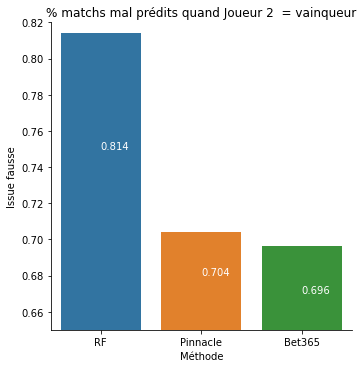

In [40]:
nb_false=len(comp2[comp2["Joueur 2"]<0.5])
false=nb_false/len(comp2)

nb_false_ps=len(comp2[comp2["PSW_prob"]<comp2["PSL_prob"]])
false_ps=nb_false_ps/len(comp2)

nb_false_b=len(comp2[comp2["B365W_prob"]<comp2["B365L_prob"]])
false_b=nb_false_b/len(comp2)

df_false_J2=pd.DataFrame({"Méthode":["RF","Pinnacle","Bet365"],"Issue fausse":[false,false_ps,false_b]})
sns.catplot("Méthode","Issue fausse",data=df_false_J2,kind="bar");
plt.ylim([0.65,0.82]);
plt.title("% matchs mal prédits quand Joueur 2  = vainqueur");
plt.text(0,0.75,round(false,3),color="white");
plt.text(1,0.68,round(false_ps,3),color="white");
plt.text(2,0.67,round(false_b,3),color="white");

On voit que notre modèle a plus de mal à prédire l'issue du match quand le joueur non favori gagne. 

### Comparaison de la faiblesse de prédiction de la classe "Joueur 1" <a class="anchor" id="section_3_6_4"></a>

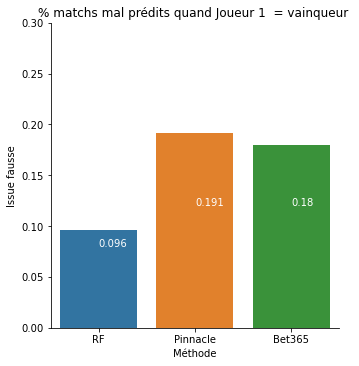

In [41]:
# Même exercice quand Joueur 1 (favori gagne)
nb_false1=len(comp1[comp1["Joueur 1"]<0.5])
false1=nb_false1/len(comp1)

nb_false_ps1=len(comp1[comp1["PSW_prob"]<comp1["PSL_prob"]])
false_ps1=nb_false_ps1/len(comp2)

nb_false_b1=len(comp1[comp1["B365W_prob"]<comp1["B365L_prob"]])
false_b1=nb_false_b1/len(comp2)

df_false_J1=pd.DataFrame({"Méthode":["RF","Pinnacle","Bet365"],"Issue fausse":[false1,false_ps1,false_b1]})
sns.catplot("Méthode","Issue fausse",data=df_false_J1,kind="bar");
plt.ylim([0,0.3]);
plt.title("% matchs mal prédits quand Joueur 1  = vainqueur ");
plt.text(0,0.08,round(false1,3),color="white");
plt.text(1,0.12,round(false_ps1,3),color="white");
plt.text(2,0.12,round(false_b1,3),color="white");

On remarque dans ce cas-là que notre modèle a moins tendance à se tromper que celui des bookmakers. C'est dû au fait que notre modèle se base principalement sur le classement elo, et donc prédit très bien quand le joueur favori gagne. Les bookmakers, eux, prennent plus de paramètres en compte.

### Comparaison de la faiblesse de prédiction des deux classes confondues <a class="anchor" id="section_3_6_5"></a>

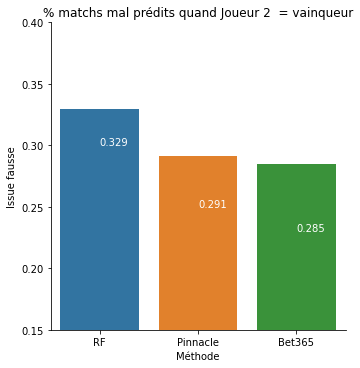

In [135]:
false_all=1-grid_rf.score(X_test_scaled,y_test)

false_ps_all=len(comp0[comp0["PSW_prob"]<comp0["PSL_prob"]])/len(comp0)

false_b_all=len(comp0[comp0["B365W_prob"]<comp0["B365L_prob"]])/len(comp0)

df_false_all=pd.DataFrame({"Méthode":["RF","Pinnacle","Bet365"],"Issue fausse":[false_all,false_ps_all,false_b_all]})
sns.catplot("Méthode","Issue fausse",data=df_false_all,kind="bar");
plt.ylim([0.15,0.4]);
plt.title("% matchs mal prédits");
plt.text(0,0.3,round(false_all,3),color="white");
plt.text(1,0.25,round(false_ps_all,3),color="white");
plt.text(2,0.23,round(false_b_all,3),color="white");

Au global, notre modèle va se tromper plus de fois que les bookmakers.

### Conclusion
Notre modèle performe particulièrement lorsqu'il s'agit de prédire la victoire du joueur favori, au point de battre les bookmakers.
En revanche, lorsqu'il s'agit de détecter une victoire du joueur non favori, le modèle a plus de mal.
Ce qui serait intéressant de comparer, c'est quand à la fois notre modèle et les probas des bookmakers ont eu tort, qui avait la probabilité la plus haute ?
Si notre modèle a faux mais avait prédit que le Joueur 2 avait 40% de chances de gagner, alors que par exemple Bet365 avait seulement prédit une victoire du Joueur 2 à 30%, alors notre modèle pourrait permettre une stratégie de pari.

Cette stratégie sera l'objet de la partie finale.
Nous allons tout d'abord regarder les performances d'un modèle qui prendrait cette fois en compte les côtes des bookmakers.

## 3-7. Création d'un modèle Random Forest en gardant les côtes comme variables explicatives <a class="anchor" id="section_3_7"></a>

In [286]:
# On remplace les valeurs manquantes des côtes sportives par des 0
atp_ml2=atp_ml
atp_ml2[["PSW","PSL","B365W","B365L"]]=atp_ml2[["PSW","PSL","B365W","B365L"]].fillna(0)

In [261]:
atp_ml2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41459 entries, 0 to 41458
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             41459 non-null  object 
 1   Best of          41459 non-null  int64  
 2   J1               41459 non-null  int64  
 3   J2               41459 non-null  int64  
 4   diff_rankJ1J2    41459 non-null  int64  
 5   diff_eloJ1J2     41459 non-null  float64
 6   win%_surface_J1  41459 non-null  float64
 7   win%_surface_J2  41459 non-null  float64
 8   PSW              41459 non-null  float64
 9   PSL              41459 non-null  float64
 10  B365W            41459 non-null  float64
 11  B365L            41459 non-null  float64
 12  proba_elo        41459 non-null  float64
 13  Gagnant          41459 non-null  object 
dtypes: float64(8), int64(4), object(2)
memory usage: 4.4+ MB


In [287]:
# On sépare nos données en target et data, en gardant les côtes comme variables explicatives
target2=atp_ml2.Gagnant
data2=atp_ml2.drop(["Best of","proba_elo","Date","Gagnant","J1","J2"],axis=1)#on supprime les données inutiles, y compris "Best of" qui a eu peu d'importance dans notre premier modèle

# On sépare en test et train set
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train, y_test = train_test_split(data2, target2, test_size = 0.2,shuffle=False,random_state=25)

In [288]:
y_test.value_counts()

Joueur 1    5597
Joueur 2    2695
Name: Gagnant, dtype: int64

In [289]:
#On scaler en utilisant MinMax
from sklearn import preprocessing
scaler2 = preprocessing.MinMaxScaler()
X_train_scaled2 = pd.DataFrame(scaler2.fit_transform(X_train2),index=X_train2.index,columns=X_train2.columns)
X_test_scaled2 = pd.DataFrame(scaler2.transform(X_test2),index=X_test2.index,columns=X_test2.columns)

In [290]:
X_train_scaled2.head()

,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2,PSW,PSL,B365W,B365L
0,0.496049,0.000000,0.476190,0.500000,0.0,0.0,0.0,0.0
1,0.514402,0.018917,0.200000,0.333333,0.0,0.0,0.0,0.0
2,0.480500,0.018917,0.473684,0.575758,0.0,0.0,0.0,0.0
3,0.437165,0.018917,0.000000,0.250000,0.0,0.0,0.0,0.0
4,0.481264,0.018955,0.200000,0.444444,0.0,0.0,0.0,0.0


In [291]:
# Modèle RF avec GridSearchCV
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=5, shuffle=True)
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
clf_rf2=ensemble.RandomForestClassifier(n_jobs=-1)
param_grid_rf={"n_estimators":[10,100,250],"min_samples_leaf":[1,3,5],"max_features":['sqrt',"log2"]}
grid_rf2=GridSearchCV(estimator=clf_rf2,param_grid=param_grid_rf,scoring="accuracy",cv=cv)
grille_rf2=grid_rf2.fit(X_train_scaled2, y_train)
print(pd.DataFrame.from_dict(grille_rf2.cv_results_).loc[:,["params","mean_test_score","std_test_score"]])

                                               params  mean_test_score  \
0   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.824977   
1   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.833389   
2   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.834263   
3   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.831790   
4   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.837067   
5   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.837851   
6   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.833509   
7   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.838665   
8   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.839660   
9   {'max_features': 'log2', 'min_samples_leaf': 1...         0.824464   
10  {'max_features': 'log2', 'min_samples_leaf': 1...         0.834173   
11  {'max_features': 'log2', 'min_samples_leaf': 1...         0.834564   
12  {'max_features': 'log2', 'min_samp

In [293]:
grid_rf2.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 250}

In [294]:
from sklearn.metrics  import classification_report
y_pred_rf2=grid_rf2.predict(X_test_scaled2)
report3=classification_report(y_test, y_pred_rf2,output_dict=True)
df_rf2=pd.DataFrame.from_dict(report3).transpose()
df_rf2

,precision,recall,f1-score,support
Joueur 1,0.884662,0.905842,0.895127,5597.000000
Joueur 2,0.794221,0.754731,0.773973,2695.000000
accuracy,0.856729,0.856729,0.856729,0.856729
macro avg,0.839442,0.830287,0.834550,8292.000000
weighted avg,0.855268,0.856729,0.855750,8292.000000


En utilisant le même modèle que lors de la première partie (en règlant à nouveau les hyperparamètres), et en gardant les côtes des Bookmakers comme variables explicatives, on remarque que cela augmente sensiblement nos métriques, surtout sur la prédiction de la classe "Joueur 2".
On pourra se servir ce de modèle pour notre stratégie de gain.

### Feature importance

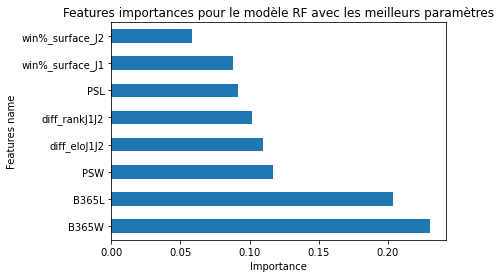

In [19]:
rf2=ensemble.RandomForestClassifier(n_estimators=250,max_features="sqrt",min_samples_leaf=5)
rf2.fit(X_train_scaled2,y_train)
pd.Series(rf2.feature_importances_,X_train_scaled2.columns).sort_values(ascending=False).plot(kind="barh");
plt.title("Features importances pour le modèle RF avec les meilleurs paramètres");
plt.ylabel("Features name");
plt.xlabel("Importance");

On remarque que les côtes B365 servent énormement à influencer nos prédictions.
Pinnacle un peu moins, surtout la côte donnée au perdant. Cela à tendance à montrer que Pinnacle a tendance à moins bien prédire que Bet365 (ce qui confirme nos analyses en début de projet.)

Représentons maintenant graphiquement la précision de notre modèle par rapport aux deux bookmakers.

In [65]:
data

,diff_rankJ1J2,diff_eloJ1J2,win%_surface_J1,win%_surface_J2,PSW,PSL,B365W,B365L
0,14,0.000000,0.476190,0.500000,0.00,0.00,0.00,0.00
1,3,16.636459,0.000000,0.500000,0.00,0.00,0.00,0.00
2,51,16.000000,0.744186,0.571429,0.00,0.00,0.00,0.00
3,123,16.770140,0.660714,0.250000,0.00,0.00,0.00,0.00
4,25,14.596222,0.166667,0.458333,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
41454,11,147.836445,0.577935,0.653736,1.75,2.24,1.66,2.20
41455,-4,62.994689,0.714286,0.662281,1.98,1.94,1.90,1.90
41456,4,31.465352,0.369231,0.000000,1.85,2.09,1.90,1.90
41457,53,208.327712,0.577935,0.000000,1.38,3.38,1.36,3.25


In [295]:
#On transforme nos côtes en probabilités 
atp_ml2["PSW_prob"]=round(1/atp_ml2["PSW"],4)
atp_ml2["PSL_prob"]=round(1/atp_ml2["PSL"],4)
atp_ml2["B365W_prob"]=round(1/atp_ml2["B365W"],4)
atp_ml2["B365L_prob"]=round(1/atp_ml2["B365L"],4)

#Caclul probalités bookmakers sur le set de test
atp_cotes=atp_ml2.loc[33167:,["Gagnant","PSW","PSL","PSW_prob","PSL_prob","B365W","B365L","B365W_prob","B365L_prob"]] 

# On calcule les probabilités de notre nouveau modèle
probs2 = pd.DataFrame(grid_rf2.predict_proba(X_test_scaled2),index=range(33167,41459),columns=["Joueur 1","Joueur 2"])
probs2

,Joueur 1,Joueur 2
33167,0.995999,0.004001
33168,0.869529,0.130471
33169,1.000000,0.000000
33170,0.987180,0.012820
33171,1.000000,0.000000
...,...,...
41454,1.000000,0.000000
41455,0.569152,0.430848
41456,0.430373,0.569627
41457,0.977684,0.022316


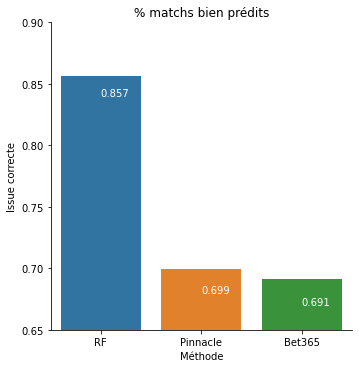

In [361]:
proba_comp=pd.merge(atp_cotes,probs2,left_index=True,right_index=True,how="inner")

true=grid_rf2.score(X_test_scaled2,y_test)

true_ps=len(proba_comp[proba_comp["PSW_prob"]>proba_comp["PSL_prob"]])/len(proba_comp)

true_b=len(proba_comp[proba_comp["B365W_prob"]>proba_comp["B365L_prob"]])/len(proba_comp)

df_true=pd.DataFrame({"Méthode":["RF","Pinnacle","Bet365"],"Issue correcte":[true,true_ps,true_b]})
sns.catplot("Méthode","Issue correcte",data=df_true,kind="bar");
plt.ylim([0.65,0.90]);
plt.title("% matchs bien prédits");
plt.text(0,0.84,round(true,3),color="white");
plt.text(1,0.68,round(true_ps,3),color="white");
plt.text(2,0.67,round(true_b,3),color="white");

Cet algorithme est plus performant que les prédictions des bookmakers. On va pouvoir s'en servir pour établir une stratégie de pari.

Cette stratégie sera l'objet de la partie suivante.

# Chapitre 4 : Stratégie de pari <a class="anchor" id="chapter4"></a>
Dans cette partie, nous allons utiliser le dernier modèle de Machine Learning créé pour établir une stratégie de pari avec le meilleur retour sur investissement.

NB : ce n'est pas parce que Bet365 prédit en général mieux les matchs que Pinnacle que parier sur Bet365 est plus avantageux. En effet, tout dépend des commissions et des côtes associées. Nous comparerons donc une stratégie de pari incluant les deux bookmakers.
    
Nous allons nous concentrer sur une stratégie de pari sur le set de test uniquement, car nous avons toutes les côtes des bookmakers sur ces données, et c'est sur ce test que nous avons prédit des résulats.

Méthode : On va préparer une base de données d'analyse contenant, pour le set de test (X_test):
- Le gagnant du match "Joueur 1" ou "Joueur 2"
- Les côtes PS et Bet 365 pour le vainqueur ou le gagnant, présente dans le dataset initial : PSW,PLS,B365W,B365L
- Les probabilités associées, qui sont égales à l'inverse des côtes: PS_prob,PW_prob...
- Les côtes PS et Bet 365 pour le Joueur 1 ou 2, indépendemment du gagnant :PS_cote_J1,PS_cote_J2,.... Par exemple, dans le cas où le Gagnant est le Joueur 1, PS_cote_J1 = PSW et PS_cote_J2=PSL, et inversement.
- Notre prédiction de vainqueur avec le modèle choisi : "Prediction "= "Joueur 1" ou "Joueur 2"
- La probabilité de notre modèle que le Joueur 1 ou le Joueur 2 gagne, qui a été calculé avec la méthode predict_proba de notre classifier.

In [362]:
# Préparation du dataset d'analyse de ROI
proba_comp["Prediction"]=y_pred_rf2
proba_comp["PS_cote_J1"]=np.nan
proba_comp["PS_cote_J2"]=np.nan
proba_comp["B365_cote_J1"]=np.nan
proba_comp["B365_cote_J2"]=np.nan
for i in range(33167,41459):
    proba_comp.loc[i,"PS_cote_J1"]=1/proba_comp.loc[i,"PSW_prob"] if proba_comp.loc[i,"Gagnant"]=="Joueur 1" else 1/proba_comp.loc[i,"PSL_prob"]
    proba_comp.loc[i,"PS_cote_J2"]=1/proba_comp.loc[i,"PSW_prob"] if proba_comp.loc[i,"Gagnant"]=="Joueur 2" else 1/proba_comp.loc[i,"PSL_prob"]
    proba_comp.loc[i,"B365_cote_J1"]=1/proba_comp.loc[i,"B365W_prob"] if proba_comp.loc[i,"Gagnant"]=="Joueur 1" else 1/proba_comp.loc[i,"B365L_prob"]
    proba_comp.loc[i,"B365_cote_J2"]=1/proba_comp.loc[i,"B365W_prob"] if proba_comp.loc[i,"Gagnant"]=="Joueur 2" else 1/proba_comp.loc[i,"B365L_prob"]

proba_comp=proba_comp.rename(columns={"Joueur 1": "Proba_Modèle_J1","Joueur 2" : "Proba_Modèle_J2"})
proba_comp=proba_comp[["Gagnant","PSW","PSL",'PSW_prob', 'PSL_prob','PS_cote_J1','PS_cote_J2', 'B365W', 'B365L','B365W_prob', 'B365L_prob','B365_cote_J1', 'B365_cote_J2',"Prediction","Proba_Modèle_J1","Proba_Modèle_J2"]]
proba_comp.head()

,Gagnant,PSW,PSL,PSW_prob,PSL_prob,PS_cote_J1,PS_cote_J2,B365W,B365L,B365W_prob,B365L_prob,B365_cote_J1,B365_cote_J2,Prediction,Proba_Modèle_J1,Proba_Modèle_J2
33167,Joueur 1,1.26,4.30,0.7937,0.2326,1.259922,4.299226,1.20,4.33,0.8333,0.2309,1.200048,4.330879,Joueur 1,0.995999,0.004001
33168,Joueur 1,1.65,2.39,0.6061,0.4184,1.649893,2.390057,1.53,2.37,0.6536,0.4219,1.529988,2.370230,Joueur 1,0.869529,0.130471
33169,Joueur 1,1.11,8.36,0.9009,0.1196,1.110001,8.361204,1.10,7.00,0.9091,0.1429,1.099989,6.997901,Joueur 1,1.000000,0.000000
33170,Joueur 1,1.43,3.10,0.6993,0.3226,1.430001,3.099814,1.36,3.00,0.7353,0.3333,1.359989,3.000300,Joueur 1,0.987180,0.012820
33171,Joueur 1,1.22,5.01,0.8197,0.1996,1.219959,5.010020,1.20,4.33,0.8333,0.2309,1.200048,4.330879,Joueur 1,1.000000,0.000000


## 4-1. Stratégie 1 : parier sur les matchs uniquement en fonction des côtes <a class="anchor" id="section_4_1"></a>
Dans cette partie, on va calculer le retour sur investissement (gain - somme misée)/somme misée, en se basant uniquement sur les **valeurs des côtes** (en mettant nos prédictions de côtés).
On va ainsi parier en misant sur la côte la plus faible. Ainsi, pour chaque match du dataset, on mise sur le favori donné par les bookmakers.
On ne gagnera ainsi  de l'argent que si PSW<PSL ou B365W<B365L, et on en perd si PSL<PSW ou B365L<B365W.

On va regarder l'évolution de notre ROI en fonction du nombre de matchs sur lesquels on parie (5% du dataset, 10%, 15%...)

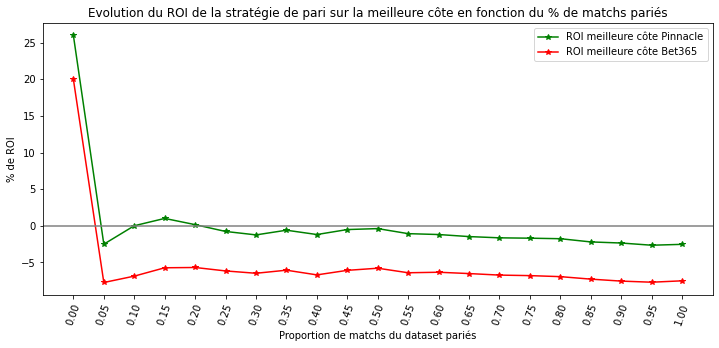

In [363]:
# Calcul des ROI Pinnacle et Bet365

roi_pin=[] #Liste qui stockera les ROI avec pari sur Pinnacle
roi_b365=[] #Liste qui stockera les ROI avec pari sur Bet365

per=np.arange(0,1.01,0.05) # va nous permettre de prendre un % du dataset

for i in range(len(per)):
    row=int(len(proba_comp)*per[i]+1) #on isole le numéro de ligne jusqu'où nos paris vont en fonction du %
    proba_comp_i=proba_comp.iloc[:row,:] #on isole la portion du dataset concerné
    roi_pin.append(round(100*(proba_comp_i.PSW[proba_comp_i.PSW<proba_comp_i.PSL].sum()-len(proba_comp_i))/len(proba_comp_i),2))
    roi_b365.append(round(100*(proba_comp_i.B365W[proba_comp_i.B365W<proba_comp_i.B365L].sum()-len(proba_comp_i))/len(proba_comp_i),2))

plt.figure(figsize=(12,5));
plt.plot(per,roi_pin,"g-*",label="ROI meilleure côte Pinnacle");
plt.plot(per,roi_b365,"r-*",label="ROI meilleure côte Bet365");
plt.axhline(y=0,color="grey")
plt.xlabel('Proportion de matchs du dataset pariés');
plt.xticks(np.arange(0,1.01,0.05),rotation=70)
plt.ylabel("% de ROI");
plt.title("Evolution du ROI de la stratégie de pari sur la meilleure côte en fonction du % de matchs pariés");
plt.legend();

Comme on peut le voir, les bookmakers font bien leur travail car on perd d'argent assez rapidement en misant régulièrement sur le favori.
Les courbes se stabilisent dans le temps ce qui est normal étant donné que les matchs sont choisis au hasard : au bout d'un moment le ROI est le même que l'on parie sur 1000 ou 5000 matchs.
    
*NB : Le ROI est positif quand on parie sur moins de 3% des matchs, soit 248 matchs.Ceci n'est pas à considérer sérieusement car ça peut être dû à un début de dataset avec un hasard de côtes particulièrement élevées même pour le Gagnant.*

Pinnacle mérite sa réputation d'avoir les côtes les plus intéressantes pour les parieurs. Bet365, au contraire, semble prévoir des marges plus importantes.

## 4-2. Stratégie 2 : pari sur tous les résultats des matchs en fonction des prédictions de notre algorithme <a class="anchor" id="section_4_2"></a>
La stratégie ici est de parier en fonction des résultats purs et durs de notre modèle : on va parier sur le Joueur 2 quand notre modèle prédit une victoire du Joueur 2, et sur le Joueur 1 inversement.

Notre retour sur investissement serait égal à la différence entre l'argent gagné au final et le total des sommes investies.
Le code ci-dessous nous permet de construire le dataset récupérant les côtes liées au numéro de Joueur : 1 ou 2 (et non pas W ou L comme dans le dataset de base).

Nous allons regarder quel sera notre retour sur investissement (d'un côté Pinnacle, de l'autre Bet365) en fonction de trois positionnements:
- Pari sur les victoires Joueur 1 et Joueur 2
- Pari sur la victoire du Joueur non favori (Joueur 2 dans notre modèle)
- Pari sur la victoire du Joueur favori (Joueur 1 dans notre modèle)

On part de l'hypothèse qu'on parie la même somme sur tous les matchs. On veut voir l'évolution du ROI en fonction du nombre de matchs du test set sur lesquels on prédit.
On va constuire un graphique qui montre l'évolution des ROI des 3 stratégie en fonction du % de matchs pariés.

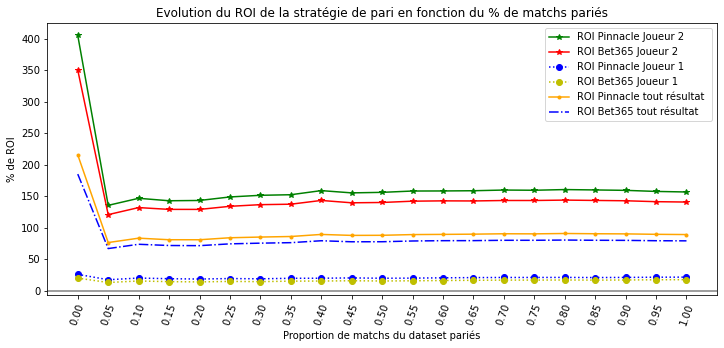

In [371]:
# ROI avec pari sur le Joueur non favori (2)
roi_ps_2=[]
roi_bet_2=[]
per=np.arange(0,1.01,0.05) # va nous permettre de prendre un % du dataset

for i in range(len(per)):
    proba_comp_2=proba_comp[proba_comp["Prediction"]=="Joueur 2"]#on sélectionne seulement la partie du dataset ou notre modèle donne le Joueur 2 Gagnant
    row=int(len(proba_comp_2)*per[i]+1)#on isole le numéro de ligne jusqu'où nos paris vont en fonction du %
    proba_comp_2=proba_comp_2.iloc[:row,:]#on isole la portion du dataset concerné
    roi_ps_2.append(round(100*(proba_comp_2.loc[proba_comp_2["Gagnant"]=="Joueur 2","PS_cote_J2"].sum()-len(proba_comp_2))/len(proba_comp_2),2))
    roi_bet_2.append(round(100*(proba_comp_2.loc[proba_comp_2["Gagnant"]=="Joueur 2","B365_cote_J2"].sum()-len(proba_comp_2))/len(proba_comp_2),2))


# ROI avec pari sur le Joueur non favori (1)
roi_ps_1=[]
roi_bet_1=[]
for i in range(len(per)):
    proba_comp_1=proba_comp[proba_comp["Prediction"]=="Joueur 1"]
    row=int(len(proba_comp_1)*per[i]+1)
    proba_comp_1=proba_comp_1.iloc[:row,:]
    roi_ps_1.append(round(100*(proba_comp_1.loc[proba_comp_1["Gagnant"]=="Joueur 1","PS_cote_J1"].sum()-len(proba_comp_1))/len(proba_comp_1),2))
    roi_bet_1.append(round(100*(proba_comp_1.loc[proba_comp_1["Gagnant"]=="Joueur 1","B365_cote_J1"].sum()-len(proba_comp_1))/len(proba_comp_1),2))

# ROI avec pari sur tous les joueurs - moyenne des deux ROI
roi_ps=[]
roi_bet=[]
for i in range(len(per)):
    roi_ps.append((roi_ps_1[i]+roi_ps_2[i])/2)
    roi_bet.append((roi_bet_1[i]+roi_bet_2[i])/2)

plt.figure(figsize=(12,5));
plt.plot(per,roi_ps_2,"g-*",label="ROI Pinnacle Joueur 2");
plt.plot(per,roi_bet_2,"r-*",label="ROI Bet365 Joueur 2");
plt.plot(per,roi_ps_1,'b:o',label="ROI Pinnacle Joueur 1");
plt.plot(per,roi_bet_1,'y:o',label="ROI Bet365 Joueur 1");
plt.plot(per,roi_ps,color="orange",marker=".",label="ROI Pinnacle tout résultat ");
plt.plot(per,roi_bet,'b-.',label="ROI Bet365 tout résultat");
plt.axhline(y=0,color="grey")
plt.xlabel('Proportion de matchs du dataset pariés');
plt.xticks(np.arange(0,1.01,0.05),rotation=70)
plt.ylabel("% de ROI");
plt.title("Evolution du ROI de la stratégie de pari en fonction du % de matchs pariés");
plt.legend();

In [368]:
len(proba_comp_1)+len(proba_comp_2)

8292

**Commentaire**

On voit qu'il est moins intéressant de ne parier que sur le joueur favori, ce qui est plutot logique.

Il semble plus intéressant de se concentrer sur le pari des 250 premiers matchs (3%).Cependant, ce bon ROI au départ est peut-être dû à des côtes favorables en début de dataset, comme on l'a expliqué pour la première stratégie.

A partir de 5% des matchs, les courbes de ROI se stabilisent logiquement.

Pour une stratégie optimale; il faudrait se concentrer sur la des paris sur le Joueur 2 et optimiser le nombre et l'ordre des matchs sur lesquels on parie au moyen d'un **intervalle de confiance**. On abordera ça dans la partie suivante.

Les calculs nous font comprendre une dernière chose : Il est plus rentable de parier sur la plateforme Pinnacle que sur Bet365. Ce dernier bookmarker semble mieux calculer ses marges.

## 4-3. Stratégie 3 : intervalle de confiance <a class="anchor" id="section_4_3"></a>
Dans cette 3e et dernière stratégie, nous allons regarder en détail les prédictions de **probabilités** de notre modèle (probabilité que tel ou tel Joueur gagne).

Au lieu de prendre les matchs dans l'ordre du dataset, on va se focaliser en premier sur les matchs avec le plus haut intervalle de confiance.

ATTENTION, cela ne veut pas dire que l'on souhaite miser sur les matchs sur lesquels on est confiant sur le gagnant, mais les matchs dont nos probabilités sont très différentes de celles des bookmakers.
La seule variable que nous devrons faire varier est donc l'écart entre notre probabilité et celles des bookmakers chez lesquels nous souhaitons parier : probabilité du modèle/probabilité du bookmaker.

On va se concentrer sur Pinnacle, dont les cotes permettent d'avoir un ROI plus intéressant, et sur le pari sur le Joueur 2 (non favori).

In [369]:
# on créé une colonne intervalle de confiance, qui représente la division entre notre probabilité et celle de Pinnacle
str3=proba_comp.loc[proba_comp["Prediction"]=="Joueur 2",["Gagnant","PS_cote_J2","Proba_Modèle_J2","Prediction"]]
str3["PS_proba_J2"]=1/str3["PS_cote_J2"]
str3['conf']=round((str3["Proba_Modèle_J2"])/str3["PS_proba_J2"],2)
str3=str3.sort_values(by="conf",ascending=False)
str3.head()

,Gagnant,PS_cote_J2,Proba_Modèle_J2,Prediction,PS_proba_J2,conf
37383,Joueur 2,31.347962,0.999500,Joueur 2,0.0319,31.33
38568,Joueur 2,27.247956,0.999500,Joueur 2,0.0367,27.23
36671,Joueur 2,24.509804,0.998833,Joueur 2,0.0408,24.48
33538,Joueur 2,23.474178,1.000000,Joueur 2,0.0426,23.47
35593,Joueur 2,22.727273,1.000000,Joueur 2,0.0440,22.73


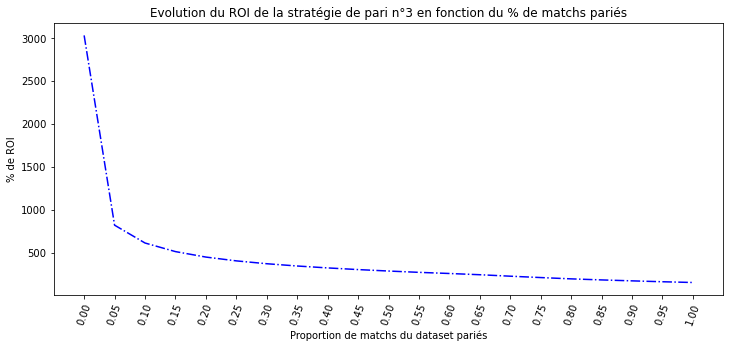

In [372]:
# Calcul du ROI en fonction du % de matchs pariés
str3_ps=[]
for i in range(len(per)):
    row=int(len(str3)*per[i]+1)
    str3_i=str3.iloc[:row,:]
    str3_ps.append(round(100*(str3_i.loc[str3_i["Gagnant"]=="Joueur 2","PS_cote_J2"].sum()-len(str3_i))/len(str3_i),2))

plt.figure(figsize=(12,5));
plt.plot(per,str3_ps,'b-.'); 
plt.xlabel('Proportion de matchs du dataset pariés');
plt.xticks(np.arange(0,1.01,0.05),rotation=70)
plt.ylabel("% de ROI");
plt.title("Evolution du ROI de la stratégie de pari n°3 en fonction du % de matchs pariés");

Au fur et à mesure du temps, le ROI de cette stratégie se stabilise pour rejoindre le niveau remarqué dans la stratégie de paris n°2 avec matchs pris dans un ordre non réfléchi.

Grâce à cette stratégie, on peut obtenir à court terme un plus fort ROI que ceux précédemment calculés.
Attention cependant, le fort ROI de 3000% peut-être dû encore une fois à une "chance" créée par des matchs à l'issue particulièrement intéressante, mais qui restent rares.

Cette stratégie est la meilleure à choisir dans notre quête de battre les bookmakers.


# Conclusion générale <a class="anchor" id="chapter5"></a>

Notre analyse nous a permis, à partir d'un dataset contenant 8 années de match de tennis, de construire deux choses:
- Un modèle prédictif de résultats sans prendre en compte les côtes des bookmakers, qui est cependant assez performant dans sa capacité de prédiction, et se rapproche de la précision des bookmakers
- Un modèle prédictif qui s'appuie sur les côtes pour nous aider à dessiner une stratégie de pari gagnante